## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score

import requests
import json
from datetime import datetime
import calendar
from dateutil.relativedelta import relativedelta

In [2]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

## 데이터

In [3]:
train = pd.read_csv('train.csv').copy()
test = pd.read_csv('test.csv').copy()
submission = pd.read_csv('sample_submission.csv')

train.shape, test.shape, submission.shape

((1205, 12), (50, 10), (50, 3))

In [132]:
train.tail()

,일자,연도,월,일,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,...,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법,중식계,석식계,중식비율,석식비율
1200,2021-01-20,2021,1,20,3,2983,75,198,4,391,...,0.0,0.0,0.0,0.0,9,5,1093,421,0.471324,0.181544
1201,2021-01-21,2021,1,21,4,2983,92,231,462,351,...,0.0,1.0,0.0,0.0,3,2,832,353,0.360329,0.152880
1202,2021-01-22,2021,1,22,5,2983,255,248,1,303,...,0.0,0.0,0.0,0.0,5,4,579,217,0.265962,0.099678
1203,2021-01-25,2021,1,25,1,2983,107,153,616,327,...,0.0,0.0,0.0,0.0,7,7,1145,502,0.477880,0.209516
1204,2021-01-26,2021,1,26,2,2983,69,183,551,362,...,0.0,0.0,0.0,0.0,2,3,1015,480,0.428451,0.202617


In [5]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,금,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,월,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,화,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


## 전처리

### 데이터 타입 변경

In [6]:
# 일자, 현본사소속재택근무자수, 중식계, 석식계 데이터 타입 변경

# train
train["일자"] = pd.to_datetime(train["일자"])
train["현본사소속재택근무자수"] = train["현본사소속재택근무자수"].astype("int")
train["중식계"] = train["중식계"].astype("int")
train["석식계"] = train["석식계"].astype("int")
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   int32         
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int32         
 11  석식계             1205 non-null   int32         
dtypes: datetime64[ns](1), int32(3), int64(4), object(4)
memory usage: 99.0+ KB


In [7]:
# test
test["일자"] = pd.to_datetime(test["일자"])
test["현본사소속재택근무자수"] = test["현본사소속재택근무자수"].astype("int")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     object        
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     int32         
 7   조식메뉴            50 non-null     object        
 8   중식메뉴            50 non-null     object        
 9   석식메뉴            50 non-null     object        
dtypes: datetime64[ns](1), int32(1), int64(4), object(4)
memory usage: 3.8+ KB


### 파생변수 만들기
연도, 월, 일, 출근인원, 중식_신메뉴, 석식_신메뉴, 공휴일, 조리법, 식재료

In [8]:
# train
train["연도"] = train["일자"].dt.year
train["월"] = train["일자"].dt.month
train["일"] = train["일자"].dt.day
train["요일"] = train['일자'].dt.weekday + 1

train.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,월,일
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2016,2,2


In [9]:
# test
test["연도"] = test["일자"].dt.year
test["월"] = test["일자"].dt.month
test["일"] = test["일자"].dt.day
test["요일"] = test['일자'].dt.weekday + 1

test.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,연도,월,일
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28


In [10]:
# 회사에 출근한 사람 : 본사정원수 - (본사휴가자수 + 본사출장자수 + 현본사소속재택근무자수)
train["출근인원"] = train["본사정원수"] - (train["본사휴가자수"] + train["본사출장자수"] + train["현본사소속재택근무자수"])
train.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,월,일,출근인원
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1,2401
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2016,2,2,2378


In [11]:
# 회사에 출근한 사람 : 본사정원수 - (본사휴가자수 + 본사출장자수 + 현본사소속재택근무자수)
test["출근인원"] = test["본사정원수"] - (test["본사휴가자수"] + test["본사출장자수"] + test["현본사소속재택근무자수"])
test.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,연도,월,일,출근인원
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,2355
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28,2319


In [12]:
# 중식메뉴, 석식메뉴에 'New'가 포함되어 있으면 1, 없으면 0으로 이루어진 '신메뉴' 컬럼 생성
train['중식_신메뉴'] = (train['중식메뉴'].str.contains('New')).astype(int)
train['석식_신메뉴'] = (train['석식메뉴'].str.contains('New')).astype(int)
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,월,일,출근인원,중식_신메뉴,석식_신메뉴
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1,2401,0,0


In [13]:
# test
test['중식_신메뉴'] = (test['중식메뉴'].str.contains('New')).astype(int)
test['석식_신메뉴'] = (test['석식메뉴'].str.contains('New')).astype(int)
test.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,연도,월,일,출근인원,중식_신메뉴,석식_신메뉴
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,2355,0,1


In [14]:
# 공휴일 

In [15]:
# url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"

# AUTH_KEY = "###################################"


# params = {
#     'solYear':str(2020),
#     'solMonth':str(1).zfill(2),
#     '_type':'json',
#     'ServiceKey' : AUTH_KEY
# }

# response =  requests.get(url,params=params)
# print(response.text)

# result = json.loads(response.text)

In [16]:
# def getHolidays(year,month,key):
#     url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
#     AUTH_KEY = "###################################"
        
#     params = {
#         'solYear':str(year),
#         'solMonth':str(month).zfill(2),
#         '_type':'json',
#         'ServiceKey' : AUTH_KEY
#     }

#     res = requests.get(url,params=params)
#     dic = json.loads(res.text)
#     counts = dic['response']['body']['totalCount']

#     if counts < 1 :
#         return []

#     item =  dic['response']['body']['items']['item']

#     if counts == 1:
#         return [item]

#     return item

In [17]:
# holidays =[]
# AUTH_KEY = "###################################"
# for year in range(2016,2022):
#     for month in range(1,13):
#         holidays.extend(getHolidays(year,month,AUTH_KEY))

In [18]:
# df_holiday = pd.DataFrame(holidays,columns=['locdate','dateName'])
# df_holiday.columns = ["일자", "공휴일"] 
# df_holiday.to_csv('./holiday.csv',index=None)
# pd.read_csv("./holiday.csv")

In [19]:
# 휴일 전날
holi = pd.read_csv("./holiday.csv")
holi["일자"] = holi["일자"].astype(str)
holiday_before_df = holi.copy()
holiday_before_df['일자'] = holiday_before_df['일자'].apply(lambda x : datetime.strptime(x,'%Y%m%d'))
holiday_before_df['일자'] = holiday_before_df['일자'].apply(lambda x : x - relativedelta(days=1))
holiday_before_df['일자'] = holiday_before_df['일자'].apply(lambda x : datetime.strftime(x, '%Y-%m-%d'))
holiday_before_df['공휴일'] = holi['공휴일'].apply(lambda x : 1)
holiday_before_df.columns = ['일자', '휴일전날']

holiday_before_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일자      107 non-null    object
 1   휴일전날    107 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [20]:
holiday_before_df.head(2)

,일자,휴일전날
0,2015-12-31,1
1,2016-02-06,1


In [21]:
# 휴일전날 merge
train["일자"] = train["일자"].astype(str)
train = pd.merge(train, holiday_before_df, left_on='일자', right_on='일자', how='left')
before_friday = train[train['요일']==5].index
train['휴일전날'][before_friday] = 1

train.head(2)

C:\Users\user\AppData\Local\Temp\ipykernel_20852\3845009856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['휴일전날'][before_friday] = 1


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,월,일,출근인원,중식_신메뉴,석식_신메뉴,휴일전날
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1,2401,0,0,NaN
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2016,2,2,2378,0,0,NaN


In [22]:
# 평일은 0 처리
train['휴일전날'] = train['휴일전날'].fillna(0)

In [23]:
train['휴일전날'].isnull().sum()

0

In [24]:
train[train['휴일전날'] == 1].head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,월,일,출근인원,중식_신메뉴,석식_신메뉴,휴일전날
4,2016-02-05,5,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2016,2,5,2142,0,0,1.0
6,2016-02-12,5,2601,389,156,93,0,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 (쌀:국내산) 봄동된...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909,598,2016,2,12,2056,0,0,1.0


In [25]:
# 휴일전날 merge
test["일자"] = test["일자"].astype(str)
test = pd.merge(test, holiday_before_df, left_on='일자', right_on='일자', how='left')
before_friday = test[test['요일']==5].index
test['휴일전날'][before_friday] = 1

test.head(2)

C:\Users\user\AppData\Local\Temp\ipykernel_20852\936886698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['휴일전날'][before_friday] = 1


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,연도,월,일,출근인원,중식_신메뉴,석식_신메뉴,휴일전날
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,2355,0,1,NaN
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28,2319,0,0,NaN


In [26]:
# 평일은 0 처리
test['휴일전날'] = test['휴일전날'].fillna(0)

In [27]:
test['휴일전날'].isnull().sum()

0

In [28]:
test[test['휴일전날'] == 1].head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,연도,월,일,출근인원,중식_신메뉴,석식_신메뉴,휴일전날
2,2021-01-29,5,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,2021,1,29,2170,0,0,1.0
7,2021-02-05,5,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,2021,2,5,2247,0,0,1.0


In [29]:
# 조리법

In [30]:
train['중식메뉴_1'] = train['중식메뉴'].str.split(' ')
train['석식메뉴_1'] = train['석식메뉴'].str.split(' ')

test['중식메뉴_1'] = test['중식메뉴'].str.split(' ')
test['석식메뉴_1'] = test['석식메뉴'].str.split(' ')

In [31]:
def get_token(data) :
    tokens = []
    for token in data :#하루의 중식 메뉴 
        s_list = []
        for t in token : #중식 메뉴 중 밥, 국,...
            if t.startswith('(') :
                s_list.append(t)
            elif (t.startswith('(') == False) & (len(t) > 1) :
                s_list.append(t)
            else :
                pass
        tokens.append(s_list)
    return tokens

In [32]:
train['중식_토큰'] = get_token(train['중식메뉴_1'])
train['석식_토큰'] = get_token(train['석식메뉴_1'])

In [33]:
test['중식_토큰'] = get_token(test['중식메뉴_1'])
test['석식_토큰'] = get_token(test['석식메뉴_1'])

In [34]:
def get_ingredient(data) :
    
    ing_df = pd.DataFrame(np.zeros((data.shape[0], 7)), columns = ['해산물', '소', '돼지', '닭', '오리', '채소', '재료_기타'])

    for t in range(data.shape[0]):
        token = data.중식_토큰.str[2][t]
        if '연어' in token or'골뱅이' in token or'열기' in token or'조기' in token or'탕수어' in token or'양장피' in token or'홍어' in token or'명태' in token or'적어' in token or'장어' in token or'동태' in token or'산슬' in token or'코다리' in token or'가자미' in token or'해물' in token or'생선' in token or'새우' in token or'꽁치' in token or'갈치' in token or'임연수' in token or'삼치' in token or'고등어' in token or'굴비' in token or'오징어' in token or'쭈꾸미' in token or'주꾸미' in token or'낙지' in token or'문어' in token :
            ing_df.head().at[t, '해산물'] = 1
        elif '왕갈비' in token or'소갈비' in token or'장조림' in token or'불고기' in token or'차돌' in token or'육전' in token or'너비아니' in token or'떡갈비' in token or(token.startswith('소') & (token.startswith('소세') == False)) or '함박' in token or'쇠고기' in token or'소고기' in token or'쇠' in token :
            ing_df.at[t, '소'] = 1
        elif '궁보계정' in token or'삼계탕' in token or'윙' in token or'유린기' in token or'깐풍'in token or'닭' in token or'치킨' in token or'후라이드' in token :
            ing_df.at[t, '돼지'] = 1
        elif '폭립' in token or'오향장육' in token or'동파육' in token or'히레카츠' in token or'순대' in token or'미트볼' in token or'등갈비' in token or'소세지' in token or'목살' in token or'탕수육' in token or'제육' in token or'돈' in token or'돼지' in token or'두루치기' in token or'삼겹' in token or'보쌈' in token or'족발' in token :
            ing_df.at[t, '닭'] = 1
        elif '오리' in token :
            ing_df.at[t, '오리'] = 1
        elif token.endswith('두부') or '꼬치산적' in token or '고추' in token or'양파' in token or'부추' in token or'고구마' in token or'감자' in token or'깻잎' in token or'샐러드' in token or'시금치' in token or'야채' in token :
            ing_df.at[t, '채소'] = 1
        else :
            ing_df.at[t, '재료_기타'] = 1
            pass
    return ing_df

In [35]:
train = pd.concat([train, get_ingredient(train)], axis = 1)
test = pd.concat([test, get_ingredient(test)], axis = 1)

C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\Ap

C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_20852\46408424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ing_df.head().at[t, '해산물'] = 1
C:\Users\user\Ap

In [36]:
train['중식_메인요리'] = train.중식_토큰.str[3]
test['중식_메인요리'] = test.중식_토큰.str[2]

In [37]:
train['석식_메인요리'] = 0
if train.shape[0] < 1067:
  train['석식_메인요리'] = train.석식_토큰.str[3]
else:
  train['석식_메인요리'] = train.석식_토큰.str[2]
test['석식_메인요리'] = test.석식_토큰.str[2]

In [38]:
#조리법 종류 별 컬럼 생성 함수
def get_recipe(data, col) :
    tm = col[:2]
    cat = ['전', '무침','튀김', '찜', '볶음', '조림', '구이', '훈제', '조리_기타']
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 9)), columns = [f'{tm}_{x}' for x in cat])

    for t in range(data.shape[0]) :
        try :
            token = data[col][t]
            if '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token or token.endswith('볶음') or '볶음' in token :
                recipe_df.at[t, f'{tm}_볶음'] = 1 
            elif token.endswith('데리야끼') or token.endswith('립') or '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token :
                recipe_df.at[t, f'{tm}_구이'] = 1
            elif '전병' in token or token.endswith('전') :
                recipe_df.at[t, f'{tm}_전'] = 1
            elif token.endswith('김치말이') or token.endswith('만두') or '보쌈' in token or '수육' in token or token.endswith('찜') or '찜' in token :
                recipe_df.at[t, f'{tm}_찜'] = 1
            elif '파채' in token or token.endswith('무침') or token.endswith('샐러드') or '양장피' in token :
                recipe_df.at[t, f'{tm}_무침'] = 1
            elif '오향장육' in token or '동파육' in token or token.endswith('조림') :
                recipe_df.at[t, f'{tm}_조림'] = 1
            elif '튀김' in token or '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or '고로케' in token or '유린기' in token or '탕수' in token or token.endswith('닭') or token.endswith('치킨') or token.endswith('튀김') or '너겟' in token or token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token :
                recipe_df.at[t, f'{tm}_튀김'] = 1
            elif '훈제' in token :
                recipe_df.at[t, f'{tm}_훈제'] = 1
            else :
                recipe_df.at[t, f'{tm}_조리_기타'] = 1
        except :
            recipe_df.at[t, f'{tm}_조리_기타'] = 1
    return recipe_df

In [39]:
train = pd.concat([train, get_recipe(train, '중식_메인요리')], axis = 1)
train = pd.concat([train, get_recipe(train, '석식_메인요리')], axis = 1)

In [40]:
train['중식메인조리법'] = 0
for t in range(train.shape[0]) :
  
  token = train['중식_메인요리'][t]
  if '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token or token.endswith('볶음') or '볶음' in token :
      train.loc[t, '중식메인조리법'] = 1 
  elif token.endswith('데리야끼') or token.endswith('립') or '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token :
      train.loc[t, '중식메인조리법'] = 2
  elif '전병' in token or token.endswith('전') :
      train.loc[t, '중식메인조리법'] = 3
  elif token.endswith('김치말이') or token.endswith('만두') or '보쌈' in token or '수육' in token or token.endswith('찜') or '찜' in token :
      train.loc[t, '중식메인조리법'] = 4
  elif '파채' in token or token.endswith('무침') or token.endswith('샐러드') or '양장피' in token :
      train.loc[t, '중식메인조리법'] = 5
  elif '오향장육' in token or '동파육' in token or token.endswith('조림') :
      train.loc[t, '중식메인조리법'] = 6
  elif '통닭' in token or '튀김' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or '고로케' in token or '유린기' in token or '탕수' in token or token.endswith('닭') or token.endswith('치킨') or token.endswith('튀김') or '너겟' in token or token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token :
      train.loc[t, '중식메인조리법'] = 7
  elif '훈제' in token :
      train.loc[t, '중식메인조리법'] = 8
  else :
      train.loc[t, '중식메인조리법'] = 9

In [41]:
train['석식메인조리법'] = 0
for t in range(train.shape[0]) :
  
  token = str(train['석식_메인요리'][t])
  if '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token or token.endswith('볶음') or '볶음' in token :
      train.loc[t, '석식메인조리법'] = 1 
  elif token.endswith('데리야끼') or token.endswith('립') or '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token :
      train.loc[t, '석식메인조리법'] = 2
  elif '전병' in token or token.endswith('전') :
      train.loc[t, '석식메인조리법'] = 3
  elif token.endswith('김치말이') or token.endswith('만두') or '보쌈' in token or '수육' in token or token.endswith('찜') or '찜' in token :
      train.loc[t, '석식메인조리법'] = 4
  elif '파채' in token or token.endswith('무침') or token.endswith('샐러드') or '양장피' in token :
      train.loc[t, '석식메인조리법'] = 5
  elif '오향장육' in token or '동파육' in token or token.endswith('조림') :
      train.loc[t, '석식메인조리법'] = 6
  elif '통닭' in token or '튀김' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or '고로케' in token or '유린기' in token or '탕수' in token or token.endswith('닭') or token.endswith('치킨') or token.endswith('튀김') or '너겟' in token or token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token :
      train.loc[t, '석식메인조리법'] = 7
  elif '훈제' in token :
      train.loc[t, '석식메인조리법'] = 8
  else :
      train.loc[t, '석식메인조리법'] = 9

In [42]:
test = pd.concat([test, get_recipe(test, '중식_메인요리')], axis = 1)

In [43]:
test = pd.concat([test, get_recipe(test, '석식_메인요리')], axis = 1)

In [44]:
test['중식메인조리법'] = 0
for t in range(test.shape[0]) :
  
  token = test['중식_메인요리'][t]
  if '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token or token.endswith('볶음') or '볶음' in token :
      test.loc[t, '중식메인조리법'] = 1 
  elif token.endswith('데리야끼') or token.endswith('립') or '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token :
      test.loc[t, '중식메인조리법'] = 2
  elif '전병' in token or token.endswith('전') :
      test.loc[t, '중식메인조리법'] = 3
  elif token.endswith('김치말이') or token.endswith('만두') or '보쌈' in token or '수육' in token or token.endswith('찜') or '찜' in token :
      test.loc[t, '중식메인조리법'] = 4
  elif '파채' in token or token.endswith('무침') or token.endswith('샐러드') or '양장피' in token :
      test.loc[t, '중식메인조리법'] = 5
  elif '오향장육' in token or '동파육' in token or token.endswith('조림') :
      test.loc[t, '중식메인조리법'] = 6
  elif '통닭' in token or '튀김' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or '고로케' in token or '유린기' in token or '탕수' in token or token.endswith('닭') or token.endswith('치킨') or token.endswith('튀김') or '너겟' in token or token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token :
      test.loc[t, '중식메인조리법'] = 7
  elif '훈제' in token :
      test.loc[t, '중식메인조리법'] = 8
  else :
      test.loc[t, '중식메인조리법'] = 9

In [45]:
test['석식메인조리법'] = 0
for t in range(test.shape[0]) :
  
  token = str(test['석식_메인요리'][t])
  if '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token or token.endswith('볶음') or '볶음' in token :
      test.loc[t, '석식메인조리법'] = 1 
  elif token.endswith('데리야끼') or token.endswith('립') or '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token :
      test.loc[t, '석식메인조리법'] = 2
  elif '전병' in token or token.endswith('전') :
      test.loc[t, '석식메인조리법'] = 3
  elif token.endswith('김치말이') or token.endswith('만두') or '보쌈' in token or '수육' in token or token.endswith('찜') or '찜' in token :
      test.loc[t, '석식메인조리법'] = 4
  elif '파채' in token or token.endswith('무침') or token.endswith('샐러드') or '양장피' in token :
      test.loc[t, '석식메인조리법'] = 5
  elif '오향장육' in token or '동파육' in token or token.endswith('조림') :
      test.loc[t, '석식메인조리법'] = 6
  elif '통닭' in token or '튀김' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or '고로케' in token or '유린기' in token or '탕수' in token or token.endswith('닭') or token.endswith('치킨') or token.endswith('튀김') or '너겟' in token or token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token :
      test.loc[t, '석식메인조리법'] = 7
  elif '훈제' in token :
      test.loc[t, '석식메인조리법'] = 8
  else :
      test.loc[t, '석식메인조리법'] = 9

In [46]:
train = train.drop(columns = ['중식메뉴_1', '석식메뉴_1',
       '중식_토큰', '석식_토큰', '해산물', '소', '돼지', '닭', '오리', '채소', '재료_기타', '중식_메인요리',
       '석식_메인요리'], axis = 1)
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '연도', '월', '일',
       '출근인원', '중식_신메뉴', '석식_신메뉴', '휴일전날', '중식_전', '중식_무침', '중식_튀김', '중식_찜',
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
       '중식메인조리법', '석식메인조리법'],
      dtype='object')

In [47]:
test = test.drop(columns = ['중식메뉴_1',
       '석식메뉴_1', '중식_토큰', '석식_토큰', '해산물', '소', '돼지', '닭', '오리', '채소', '재료_기타',
       '중식_메인요리', '석식_메인요리'], axis = 1)
test.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '연도', '월', '일', '출근인원', '중식_신메뉴',
       '석식_신메뉴', '휴일전날', '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음', '중식_조림',
       '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침', '석식_튀김', '석식_찜', '석식_볶음',
       '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타', '중식메인조리법', '석식메인조리법'],
      dtype='object')

In [48]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식_무침,석식_튀김,석식_찜,석식_볶음,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,9
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
2,2016-02-03,3,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
3,2016-02-04,4,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,9
4,2016-02-05,5,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9


In [49]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식_무침,석식_튀김,석식_찜,석식_볶음,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,9
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
2,2016-02-03,3,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
3,2016-02-04,4,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,9
4,2016-02-05,5,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9


In [50]:
# 식재료

In [51]:
# train ln
lunch = []
for day in range(len(train)):
    tmp = train.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    lunch.append(tmp)

In [52]:
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []

for i, day_menu in enumerate(lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

    if i < 1067:
        kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
        side_tmp = day_menu[-2]; side.append(side_tmp)
    else: 
        kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
        side_tmp  = day_menu[-1]; side.append(side_tmp)
        
train_ln = train.copy()
train_ln['bob'] = bob
train_ln['gook'] = gook
train_ln['banchan1'] = banchan1
train_ln['banchan2'] = banchan2
train_ln['banchan3'] = banchan3
train_ln['kimchi'] = kimchi 
train_ln['side'] = side
train_ln.iloc[1066:1070, 7:]
# train_ln.info()

,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,연도,월,일,출근인원,중식_신메뉴,...,석식_조리_기타,중식메인조리법,석식메인조리법,bob,gook,banchan1,banchan2,banchan3,kimchi,side
1066,모닝롤/와플 우유/주스 계란후라이 해물죽/쌀밥 순두부탕 노각무침 포기김치 (...,"돈육버섯고추장덮밥 (쌀,돈육:국내산) 팽이무국 양파링카레튀김 모듬어묵볶음 참나...","쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 부대찌개 (양지:호주산) 떡갈비조림 쫄면무침...",516,266,2020,6,12,2274,0,...,1.0,7,9,돈육버섯고추장덮밥,팽이무국,양파링카레튀김,모듬어묵볶음,참나물생채,포기김치,요구르트
1067,모닝롤/야채샌드 우유/주스 계란후라이 녹두죽/쌀밥 건새우무채국 쑥갓두부무침 오이보트...,쌀밥/잡곡밥 냉모밀국수 매운돈갈비찜 메밀전병*간장 고구마순볶음 포기김치 양상추샐러드...,쌀밥/잡곡밥 돈육김치찌개 깐풍기 고갈비구이 가지된장무침 포기김치,866,343,2020,7,1,2521,0,...,0.0,3,7,쌀밥/잡곡밥,냉모밀국수,매운돈갈비찜,메밀전병*간장,고구마순볶음,포기김치,양상추샐러드*딸기요거트
1068,모닝롤/크래미샌드 우유/주스 계란후라이 누룽지탕/쌀밥 참치김치찌개 느타리버섯장조림 ...,쌀밥/잡곡밥 대파육개장 홍어미나리초무침 어묵잡채 콩자반 배추겉절이 양상추샐러드*오리엔탈,"김밥 미니우동 구슬떡볶이 김말이,고추튀김 다시마채무초무침 포기김치",675,441,2020,7,2,2495,0,...,1.0,1,9,쌀밥/잡곡밥,대파육개장,홍어미나리초무침,어묵잡채,콩자반,배추겉절이,양상추샐러드*오리엔탈
1069,모닝롤/호떡 우유/주스 계란후라이 콩죽/쌀밥 북어무우국 베이컨숙주굴소스볶음 양상추샐...,카레라이스 동태알탕 부추고추전*간장 쫄면야채무침 과일요거트샐러드 포기김치 요구르트,쌀밥/잡곡밥 김치어묵국 케이준샐러드 섭산적표고굴소스볶음 매운콩나물무침 포기김치,607,269,2020,7,3,2291,0,...,0.0,5,5,카레라이스,동태알탕,부추고추전*간장,쫄면야채무침,과일요거트샐러드,포기김치,요구르트


In [53]:
# test ln 
lunch = []
for day in range(len(test)):
    tmp = test.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    lunch.append(tmp)

In [54]:
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []

for i, day_menu in enumerate(lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

    if i < 1067:
        kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
        side_tmp = day_menu[-2]; side.append(side_tmp)
    else: 
        kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
        side_tmp  = day_menu[-1]; side.append(side_tmp)

test_ln = test.copy()
test_ln['bob'] = bob
test_ln['gook'] = gook
test_ln['banchan1'] = banchan1
test_ln['banchan2'] = banchan2
test_ln['banchan3'] = banchan3
test_ln['kimchi'] = kimchi 
test_ln['side'] = side
# test_ln.iloc[1066:1070, 7:]
test_ln.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식_조리_기타,중식메인조리법,석식메인조리법,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,0.0,4,1,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,양상추샐러드*딸기D,포기김치
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,0.0,2,5,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,양상추샐러드*오미자D,겉절이김치
2,2021-01-29,5,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,0.0,7,4,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,양상추샐러드*파인요거트D,포기김치
3,2021-02-01,1,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,0.0,2,6,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,양상추샐러드*망고D,포기김치
4,2021-02-02,2,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,0.0,6,1,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,양상추샐러드*오리엔탈D,알타리김치/사과푸딩


In [55]:
# train_ln = train_ln[['year','month','day','dow','employees', 'dayoff', 'bustrip', 'ovtime', 'remote','real_emp','bob','gook','banchan1','banchan2','banchan3', 'kimchi','side','target_ln']]
# test_ln = test_ln[['year','month','day','dow','employees', 'dayoff', 'bustrip', 'ovtime', 'remote','real_emp','bob','gook','banchan1','banchan2','banchan3', 'kimchi','side']]

In [56]:
test_ln

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식_조리_기타,중식메인조리법,석식메인조리법,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,0.0,4,1,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,양상추샐러드*딸기D,포기김치
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,0.0,2,5,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,양상추샐러드*오미자D,겉절이김치
2,2021-01-29,5,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,0.0,7,4,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,양상추샐러드*파인요거트D,포기김치
3,2021-02-01,1,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,0.0,2,6,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,양상추샐러드*망고D,포기김치
4,2021-02-02,2,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,0.0,6,1,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,양상추샐러드*오리엔탈D,알타리김치/사과푸딩
5,2021-02-03,3,2924,59,199,5,286,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,...,0.0,1,2,쌀밥/흑미밥/찰현미밥,아욱국,매콤해물볶음,감자조림,미나리나물,콥샐러드*렌치D,포기김치
6,2021-02-04,4,2924,61,211,476,288,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,...,0.0,4,1,쌀밥/차조밥/찰현미밥,설렁탕,고등어김치말이찜,볼어묵굴소스볶음,브로콜리숙회*초장,양상추샐러드*키위D,석박지
7,2021-02-05,5,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,...,1.0,1,9,쌀밥/흑미밥/찰현미밥,북엇국,닭볶음탕,채소전*장,솎음열무나물무침,양상추샐러드*황도D,포기김치
8,2021-02-08,1,2924,88,174,690,329,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,...,0.0,4,7,쌀밥/흑미밥/찰현미밥,감자양파국,돈수육*씨앗쌈장,매콤어묵볶음,콩나물파채무침,양상추샐러드*자몽D,포기김치
9,2021-02-09,2,2924,94,183,542,329,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,...,0.0,2,2,쌀밥/기장밥/찰현미밥,장각백숙,적어양념장구이,채소스틱*쌈장,도라지오이초무침,양상추샐러드*참깨D,겉절이김치


In [57]:
# train_dn
dinner = []
for day in range(len(train)):
    tmp = train.iloc[day, 9].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    dinner.append(tmp)

In [58]:
dinner

[['쌀밥/잡곡밥', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치'],
 ['콩나물밥*양념장', '어묵국', '유산슬', '아삭고추무침', '바나나', '포기김치'],
 ['쌀밥/잡곡밥', '청국장찌개', '황태양념구이', '고기전', '새송이버섯볶음', '포기김치'],
 ['미니김밥*겨자장', '우동', '멕시칸샐러드', '군고구마', '무피클', '포기김치'],
 ['쌀밥/잡곡밥', '차돌박이찌개', '닭갈비', '감자소세지볶음', '콩나물무침', '포기김치'],
 ['참치회덮밥', '맑은국', '군만두', '과일샐러드', '락교', '포기김치'],
 ['쌀밥/잡곡밥', '김치콩나물국', '미니함박', '어묵볶음', '물파래무침', '깍두기'],
 ['쌀밥/잡곡밥', '홍합미역국', '등갈비김치찜', '임연수구이', '브로컬리초장', '포기김치'],
 ['쌀밥/잡곡밥', '된장찌개', '쇠불고기', '해파리겨자채', '봄동무침', '포기김치'],
 ['볶음밥*자장소스', '맑은국', '새우또띠아', '쨔샤이무침', '요플레', '포기김치'],
 ['쌀밥/잡곡밥', '순두부찌개', '명태조림', '감자채볶음', '쌈만두', '포기김치'],
 ['쌀밥/잡곡밥', '설렁탕', '김치전', '야채스틱', '바나나', '석박지'],
 ['쌀밥/잡곡밥', '옹심이만두국', '떡갈비조림', '청포묵무침', '부추오이생채', '포기김치'],
 ['쌀밥/잡곡밥', '콩비지찌개', '해물까스&타르타르소스', '볶음쌀국수', '미역레몬초무침', '통배추겉절이'],
 ['쌀밥/잡곡밥', '열무된장국', '매운돼지갈비찜', '멸치호두볶음', '숙주나물', '포기김치'],
 ['김밥', '잔치국수', '교자만두', '찜)', '멕시칸샐러드', '무피클', '포기김치'],
 ['쌀밥/잡곡밥', '닭개장', '삼치구이', '꽃맛살볶음', '청경채사과무침', '포기김치'],
 ['쌀밥/잡곡밥', '버섯들깨탕', '꽁치한마리구이', '두부양념조림', '구이김'

In [59]:
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []
for i, day_menu in enumerate(dinner):
    if (len(day_menu) < 4 ):
        bob.append('*')
        gook.append('*')
        banchan1.append('*')
        banchan2.append('*')
        banchan3.append('*')

        if i < 1067:
            kimchi.append('*')
            side.append('*')
        else: 
            kimchi.append('*')
            side.append('*')

    elif (len(day_menu)==4):
        bob_tmp = day_menu[0]; bob.append(bob_tmp)
        gook_tmp = day_menu[1]; gook.append(gook_tmp)
        banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
        banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
        banchan3.append('*')

        if i < 1067:
            kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
            side_tmp = day_menu[-2]; side.append(side_tmp)
        else: 
            kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
            side_tmp  = day_menu[-1]; side.append(side_tmp)
    
    else :
        bob_tmp = day_menu[0]; bob.append(bob_tmp)
        gook_tmp = day_menu[1]; gook.append(gook_tmp)
        banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
        banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
        banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

        if i < 1067:
            kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
            side_tmp = day_menu[-2]; side.append(side_tmp)
        else: 
            kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
            side_tmp  = day_menu[-1]; side.append(side_tmp)
    

train_dn = train.copy()

train_dn['bob'] = bob
train_dn['gook'] = gook
train_dn['banchan1'] = banchan1
train_dn['banchan2'] = banchan2
train_dn['banchan3'] = banchan3
train_dn['kimchi'] = kimchi
train_dn['side'] = side
train_dn.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식_조리_기타,중식메인조리법,석식메인조리법,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,1.0,2,9,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,포기김치,건파래무침
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,1.0,7,9,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,포기김치,바나나
2,2016-02-03,3,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,1.0,7,9,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,포기김치,새송이버섯볶음
3,2016-02-04,4,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,1.0,1,9,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,포기김치,무피클
4,2016-02-05,5,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,1.0,7,9,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,포기김치,콩나물무침


In [60]:
# test_dn
dinner = []
for day in range(len(test)):
    tmp = test.iloc[day, 9].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    dinner.append(tmp)

In [61]:
train.iloc[1, 9]

'콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국  유산슬 (쇠고기:호주산) 아삭고추무침  바나나  포기김치 (배추,고추가루:국내산) '

In [62]:
dinner

[['흑미밥', '얼큰순두부찌개', '쇠고기우엉볶음', '버섯햄볶음', '포기김치'],
 ['충무김밥', '우동국물', '오징어무침', '꽃맛살샐러드', '얼갈이쌈장무침', '석박지'],
 ['흑미밥', '물만둣국', '카레찜닭', '숯불양념꼬지어묵', '꼬시래기무침', '포기김치'],
 ['흑미밥', '동태탕', '돈육꽈리고추장조림', '당면채소무침', '모자반무침', '포기김치'],
 ['흑미밥', '바지락살국', '쇠고기청경채볶음', '두부구이*볶은김치', '머위된장무침', '백김치'],
 ['오므라이스', '가쓰오장국', '빌소세지구이*구운채소', '단감치커리무침', '양념고추지', '겉절이김치'],
 ['흑미밥', '계란파국', '돈육두루치기', '감자채파프리카볶음', '세발나물오리엔탈무침', '포기김치'],
 ['유부초밥/추가밥', '온메밀소바', '국물떡볶이', '순대찜*소금', '청경채겉절이', '포기김치'],
 ['흑미밥', '냉이국', '반반치킨', '꼬막채소무침', '청경채찜', '포기김치'],
 ['흑미밥', '미역국', '매운소불고기', '단호박두부탕수', '메추리알장조림', '석박지'],
 ['흑미밥', '참치김치찌개', '오징어굴소스볶음', '차돌비빔국수', '건새우무나물', '포기김치'],
 ['흑미밥', '순두부백탕', '수제치킨까스', '쫄면채소무침', '얼갈이나물', '포기김치'],
 ['흑미밥', '손수제비국', '쇠고기낙지볶음', '카레홍합찜', '쑥갓나물', '포기김치'],
 ['곤드레밥', '황태국', '찰떡떡갈비조림', '계란후라이', '재래김*달래양념장', '무생채'],
 ['흑미밥', '바지락된장찌개', '제육볶음', '양배추숙*쌈장', '노가리고추조림', '겉절이김치'],
 ['흑미밥', '버섯들깨탕', '아귀콩나물찜', '콤비네이션피자', '돌나물&된장소스', '포기김치'],
 ['흑미밥', '동태알탕', '깐풍육', '고사리볶음', '오이무침', '포기김치'],
 ['흑미밥', '쇠고기무국', '춘전닭갈비',

In [63]:
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []

for i, day_menu in enumerate(dinner):
    if (len(day_menu) < 4 ):
        bob.append('*')
        gook.append('*')
        banchan1.append('*')
        banchan2.append('*')
        banchan3.append('*')

        if i < 1067:
            kimchi.append('*')
            side.append('*')
        else: 
            kimchi.append('*')
            side.append('*')

    elif (len(day_menu)==4):
        bob_tmp = day_menu[0]; bob.append(bob_tmp)
        gook_tmp = day_menu[1]; gook.append(gook_tmp)
        banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
        banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
        banchan3.append('*')

        if i < 1067:
            kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
            side_tmp = day_menu[-2]; side.append(side_tmp)
        else: 
            kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
            side_tmp  = day_menu[-1]; side.append(side_tmp)
    
    else :
        bob_tmp = day_menu[0]; bob.append(bob_tmp)
        gook_tmp = day_menu[1]; gook.append(gook_tmp)
        banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
        banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
        banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

        if i < 1067:
            kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
            side_tmp = day_menu[-2]; side.append(side_tmp)
        else: 
            kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
            side_tmp  = day_menu[-1]; side.append(side_tmp)
    

test_dn = test.copy()

test_dn['bob'] = bob
test_dn['gook'] = gook
test_dn['banchan1'] = banchan1
test_dn['banchan2'] = banchan2
test_dn['banchan3'] = banchan3
test_dn['kimchi'] = kimchi
test_dn['side'] = side
test_dn.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,석식_조리_기타,중식메인조리법,석식메인조리법,bob,gook,banchan1,banchan2,banchan3,kimchi,side
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,0.0,4,1,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,포기김치,포기김치,버섯햄볶음
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,0.0,2,5,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,석박지,얼갈이쌈장무침
2,2021-01-29,5,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,0.0,7,4,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,포기김치,꼬시래기무침
3,2021-02-01,1,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,0.0,2,6,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,포기김치,모자반무침
4,2021-02-02,2,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,0.0,6,1,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,백김치,머위된장무침


In [64]:
# train_ln
원재료1 = [
    train_ln["banchan1"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    train_ln["banchan1"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    train_ln["banchan1"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    train_ln["banchan1"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    train_ln["banchan1"].str.contains('오리'),
    train_ln["banchan1"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist1 = ['해산물', '소', '닭',"돼지",'오리','채소']

train_ln['반찬1_원재료'] = np.select(원재료1, choicelist1, default='기타')

In [65]:
원재료2 = [
    train_ln["banchan2"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    train_ln["banchan2"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    train_ln["banchan2"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    train_ln["banchan2"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    train_ln["banchan2"].str.contains('오리'),
    train_ln["banchan2"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist2 = ['해산물', '소', '닭',"돼지",'오리','채소']

train_ln['반찬2_원재료'] = np.select(원재료2, choicelist2, default='기타')

In [66]:
원재료3 = [
    train_ln["banchan3"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    train_ln["banchan3"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    train_ln["banchan3"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    train_ln["banchan3"].str.contains('삽겹|폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    train_ln["banchan3"].str.contains('오리'),
    train_ln["banchan3"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist3 = ['해산물', '소', '닭',"돼지",'오리','채소']

train_ln['반찬3_원재료'] = np.select(원재료3, choicelist3, default='기타')

In [67]:
train_ln

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,bob,gook,banchan1,banchan2,banchan3,kimchi,side,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,포기김치,요구르트,소,기타,기타
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,배추겉절이,요구르트,해산물,소,기타
2,2016-02-03,3,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,포기김치,요구르트,닭,채소,기타
3,2016-02-04,4,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,포기김치,요구르트,해산물,채소,기타
4,2016-02-05,5,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,포기김치,요구르트,돼지,기타,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,3,2983,75,198,4,391,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,쌀밥/흑미밥/찰현미밥,아욱국,수제함박스테이크,견과류마카로니범벅,생깻잎지,단호박물김치,양상추샐러드*오리엔탈D,소,기타,채소
1201,2021-01-21,4,2983,92,231,462,351,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,쌀밥/수수밥/찰현미밥,냉이된장국,동파육,봄동전,청경채/버섯숙회*초장,무생채,양상추샐러드*파인D,돼지,기타,기타
1202,2021-01-22,5,2983,255,248,1,303,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,전주비빔밥*약고추장,계란파국,요거닭,올방개묵무침,파프리카해초무침,포기김치,양상추샐러드*자몽D,닭,기타,기타
1203,2021-01-25,1,2983,107,153,616,327,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,쌀밥/흑미밥/찰현미밥,전주식콩나물해장국,돈육간장불고기,깐풍연근,연두부*달래양념장,봄동겉절이/양념김,양상추샐러드*오렌지D,소,닭,채소


In [68]:
# test_ln
원재료1 = [
    test_ln["banchan1"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    test_ln["banchan1"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    test_ln["banchan1"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    test_ln["banchan1"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    test_ln["banchan1"].str.contains('오리'),
    test_ln["banchan1"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist1 = ['해산물', '소', '닭',"돼지",'오리','채소']

test_ln['반찬1_원재료'] = np.select(원재료1, choicelist1, default='기타')

In [69]:
원재료2 = [
    test_ln["banchan2"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    test_ln["banchan2"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    test_ln["banchan2"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    test_ln["banchan2"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    test_ln["banchan2"].str.contains('오리'),
    test_ln["banchan2"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist2 = ['해산물', '소', '닭',"돼지",'오리','채소']

test_ln['반찬2_원재료'] = np.select(원재료2, choicelist2, default='기타')

In [70]:
원재료3 = [
    test_ln["banchan3"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    test_ln["banchan3"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    test_ln["banchan3"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    test_ln["banchan3"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    test_ln["banchan3"].str.contains('오리'),
    test_ln["banchan3"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist3 = ['해산물', '소', '닭',"돼지",'오리','채소']

test_ln['반찬3_원재료'] = np.select(원재료3, choicelist3, default='기타')

In [71]:
test_ln

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,bob,gook,banchan1,banchan2,banchan3,kimchi,side,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,양상추샐러드*딸기D,포기김치,소,기타,기타
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,양상추샐러드*오미자D,겉절이김치,오리,채소,기타
2,2021-01-29,5,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,양상추샐러드*파인요거트D,포기김치,소,해산물,기타
3,2021-02-01,1,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,양상추샐러드*망고D,포기김치,소,기타,채소
4,2021-02-02,2,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,양상추샐러드*오리엔탈D,알타리김치/사과푸딩,닭,기타,기타
5,2021-02-03,3,2924,59,199,5,286,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,...,쌀밥/흑미밥/찰현미밥,아욱국,매콤해물볶음,감자조림,미나리나물,콥샐러드*렌치D,포기김치,해산물,채소,기타
6,2021-02-04,4,2924,61,211,476,288,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,...,쌀밥/차조밥/찰현미밥,설렁탕,고등어김치말이찜,볼어묵굴소스볶음,브로콜리숙회*초장,양상추샐러드*키위D,석박지,해산물,소,기타
7,2021-02-05,5,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,...,쌀밥/흑미밥/찰현미밥,북엇국,닭볶음탕,채소전*장,솎음열무나물무침,양상추샐러드*황도D,포기김치,닭,소,기타
8,2021-02-08,1,2924,88,174,690,329,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,...,쌀밥/흑미밥/찰현미밥,감자양파국,돈수육*씨앗쌈장,매콤어묵볶음,콩나물파채무침,양상추샐러드*자몽D,포기김치,돼지,기타,기타
9,2021-02-09,2,2924,94,183,542,329,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,...,쌀밥/기장밥/찰현미밥,장각백숙,적어양념장구이,채소스틱*쌈장,도라지오이초무침,양상추샐러드*참깨D,겉절이김치,해산물,소,기타


In [72]:
# train_dn
원재료1 = [
    train_dn["banchan1"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    train_dn["banchan1"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    train_dn["banchan1"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    train_dn["banchan1"].str.contains('삽겹|폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    train_dn["banchan1"].str.contains('오리'),
    train_dn["banchan1"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist1 = ['해산물', '소', '닭',"돼지",'오리','채소']

train_dn['반찬1_원재료'] = np.select(원재료1, choicelist1, default='기타')

In [73]:
원재료2 = [
    train_dn["banchan2"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    train_dn["banchan2"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    train_dn["banchan2"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    train_dn["banchan2"].str.contains('삽겹|폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    train_dn["banchan2"].str.contains('오리'),
    train_dn["banchan2"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist2 = ['해산물', '소', '닭',"돼지",'오리','채소']

train_dn['반찬2_원재료'] = np.select(원재료2, choicelist2, default='기타')

In [74]:
원재료3 = [
    train_dn["banchan3"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    train_dn["banchan3"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    train_dn["banchan3"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    train_dn["banchan3"].str.contains('삽겹|폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    train_dn["banchan3"].str.contains('오리'),
    train_dn["banchan3"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist3 = ['해산물', '소', '닭',"돼지",'오리','채소']

train_dn['반찬3_원재료'] = np.select(원재료3, choicelist3, default='기타')

In [75]:
train_dn

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,bob,gook,banchan1,banchan2,banchan3,kimchi,side,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2016-02-01,1,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,포기김치,건파래무침,해산물,채소,기타
1,2016-02-02,2,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,포기김치,바나나,해산물,채소,기타
2,2016-02-03,3,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,포기김치,새송이버섯볶음,해산물,기타,기타
3,2016-02-04,4,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,포기김치,무피클,기타,채소,기타
4,2016-02-05,5,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,포기김치,콩나물무침,소,소,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,3,2983,75,198,4,391,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,계란후라이,고들빼기무침,고들빼기무침,겉절이김치,소,기타,기타
1201,2021-01-21,4,2983,92,231,462,351,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,흑미밥,쇠고기무국,삼치양념구이,비엔나채소볶음,숙주나물당근무침,숙주나물당근무침,포기김치,해산물,소,기타
1202,2021-01-22,5,2983,255,248,1,303,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,흑미밥,수제비국,수제맛쵸킹탕수육,유부채소겨자냉채,참나물무침,참나물무침,갓김치/겉절이김치,돼지,소,기타
1203,2021-01-25,1,2983,107,153,616,327,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,흑미밥,열무된장국,장어강정*데리야끼소스,깻잎쌈*생강채,오이선,오이선,포기김치,해산물,채소,기타


In [76]:
# test_dn
원재료1 = [
    test_dn["banchan1"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    test_dn["banchan1"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    test_dn["banchan1"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    test_dn["banchan1"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    test_dn["banchan1"].str.contains('오리'),
    test_dn["banchan1"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist1 = ['해산물', '소', '닭',"돼지",'오리','채소']

test_dn['반찬1_원재료'] = np.select(원재료1, choicelist1, default='기타')

In [77]:
원재료2 = [
    test_dn["banchan2"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    test_dn["banchan2"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    test_dn["banchan2"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    test_dn["banchan2"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    test_dn["banchan2"].str.contains('오리'),
    test_dn["banchan2"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist2 = ['해산물', '소', '닭',"돼지",'오리','채소']

test_dn['반찬2_원재료'] = np.select(원재료2, choicelist2, default='기타')

In [78]:
원재료3 = [
    test_dn["banchan3"].str.contains("황태|연어|맛살|골뱅이|열기|조기|탕수어|양장피|홍어|명태|적어|장어|동태|산슬|코다리|가자미|해물|생선|새우|꽁치|갈치|임연수|삼치|고등어|굴비|오징어|쭈꾸미|주꾸미|낙지|문어"),
    test_dn["banchan3"].str.contains('왕갈비|소갈비|장조림|불고기|차돌|육전|너비아니|떡갈비|소|소세|함박|쇠고기|소고기|쇠|갈비'),
    test_dn["banchan3"].str.contains('궁보계정|삼계탕|윙|유린기|깐풍|닭|치킨|후라이드|장각'),
    test_dn["banchan3"].str.contains('폭립|오향장육|동파육|히레카츠|순대|미트볼|등갈비|소세지|목살|탕수육|제육|돈|돼지|두루치기|삼겹|보쌈|족발'),
    test_dn["banchan3"].str.contains('오리'),
    test_dn["banchan3"].str.contains('두부|꼬치산적|고추|양파|부추|고구마|감자|깻잎|샐러드시금치|야채'),    
]

choicelist3 = ['해산물', '소', '닭',"돼지",'오리','채소']

test_dn['반찬3_원재료'] = np.select(원재료3, choicelist3, default='기타')

In [79]:
test_dn

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,...,bob,gook,banchan1,banchan2,banchan3,kimchi,side,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2021-01-27,3,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,...,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,포기김치,포기김치,버섯햄볶음,소,기타,기타
1,2021-01-28,4,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,...,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,석박지,얼갈이쌈장무침,해산물,해산물,기타
2,2021-01-29,5,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,...,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,포기김치,꼬시래기무침,닭,기타,기타
3,2021-02-01,1,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,...,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,포기김치,모자반무침,소,소,기타
4,2021-02-02,2,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,...,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,백김치,머위된장무침,소,채소,기타
5,2021-02-03,3,2924,59,199,5,286,모닝롤/게살모닝샌드 우유/주스 계란후라이/찐계란 소고기죽/흑미밥 시래기된장국 베이컨...,쌀밥/흑미밥/찰현미밥 아욱국 매콤해물볶음 감자조림 미나리나물 포기김치 콥샐러드*렌치D,오므라이스 가쓰오장국 빌소세지구이*구운채소 단감치커리무침 양념고추지 겉절이김치,...,오므라이스,가쓰오장국,빌소세지구이*구운채소,단감치커리무침,양념고추지,겉절이김치,양념고추지,소,기타,채소
6,2021-02-04,4,2924,61,211,476,288,모닝롤/사과파이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 아욱국 새송이버섯곤약장...,쌀밥/차조밥/찰현미밥 설렁탕 고등어김치말이찜 볼어묵굴소스볶음 브로콜리숙회*초장 석박...,흑미밥 계란파국 돈육두루치기 감자채파프리카볶음 세발나물오리엔탈무침 포기김치,...,흑미밥,계란파국,돈육두루치기,감자채파프리카볶음,세발나물오리엔탈무침,포기김치,세발나물오리엔탈무침,돼지,채소,오리
7,2021-02-05,5,2924,169,252,0,256,모닝롤/앙버터모닝빵 우유/주스 계란후라이/찐계란 고구마죽/흑미밥 옹심이국 머위나물무...,쌀밥/흑미밥/찰현미밥 북엇국 닭볶음탕 채소전*장 솎음열무나물무침 포기김치 양상추샐러...,유부초밥/추가밥 온메밀소바 국물떡볶이 순대찜*소금 청경채겉절이 포기김치,...,유부초밥/추가밥,온메밀소바,국물떡볶이,순대찜*소금,청경채겉절이,포기김치,청경채겉절이,기타,소,기타
8,2021-02-08,1,2924,88,174,690,329,모닝롤/스콘 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 근대나물무침 연두부...,쌀밥/흑미밥/찰현미밥 감자양파국 돈수육*씨앗쌈장 매콤어묵볶음 콩나물파채무침 포기김치...,흑미밥 냉이국 반반치킨 꼬막채소무침 청경채찜 포기김치,...,흑미밥,냉이국,반반치킨,꼬막채소무침,청경채찜,포기김치,청경채찜,닭,소,기타
9,2021-02-09,2,2924,94,183,542,329,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 팥죽/흑미밥 맑은버섯국 시금치나물무침...,쌀밥/기장밥/찰현미밥 장각백숙 적어양념장구이 채소스틱*쌈장 도라지오이초무침 겉절이김...,흑미밥 미역국 매운소불고기 단호박두부탕수 메추리알장조림 석박지,...,흑미밥,미역국,매운소불고기,단호박두부탕수,메추리알장조림,석박지,메추리알장조림,소,채소,소


In [80]:
train_ln['반찬1_원재료'].value_counts(), train_ln['반찬2_원재료'].value_counts(),train_ln['반찬3_원재료'].value_counts()

(소      402
 해산물    300
 돼지     206
 닭      187
 오리      42
 채소      39
 기타      29
 Name: 반찬1_원재료, dtype: int64,
 기타     647
 채소     252
 해산물    228
 소       54
 닭       14
 돼지      10
 Name: 반찬2_원재료, dtype: int64,
 기타     958
 채소     205
 해산물     20
 소       14
 닭        7
 돼지       1
 Name: 반찬3_원재료, dtype: int64)

In [81]:
train_dn['반찬1_원재료'].value_counts(), train_dn['반찬2_원재료'].value_counts(),train_dn['반찬3_원재료'].value_counts()

(해산물    337
 소      252
 기타     236
 돼지     159
 닭      138
 채소      69
 오리      14
 Name: 반찬1_원재료, dtype: int64,
 기타     692
 채소     251
 해산물    167
 소       58
 돼지      20
 닭       12
 오리       5
 Name: 반찬2_원재료, dtype: int64,
 기타     1044
 채소      123
 해산물      21
 소        11
 닭         3
 오리        2
 돼지        1
 Name: 반찬3_원재료, dtype: int64)

In [82]:
train_ln = train_ln[['bob', 'gook', 'banchan1', 'banchan2', 'banchan3', 'kimchi', 'side',
        '반찬1_원재료', '반찬2_원재료', '반찬3_원재료']].copy()
test_ln = test_ln[['bob',
        'gook', 'banchan1', 'banchan2', 'banchan3', 'kimchi', 'side', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료']].copy()
train_dn = train_dn[['bob',
        'gook', 'banchan1', 'banchan2', 'banchan3', 'kimchi', 'side', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료']].copy()
test_dn = test_dn[['bob',
        'gook', 'banchan1', 'banchan2', 'banchan3', 'kimchi', 'side', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료']].copy()

In [83]:
train_ln.columns = ['밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료', '반찬2_원재료', '반찬3_원재료']
test_ln.columns = ['밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료', '반찬2_원재료', '반찬3_원재료']
train_dn.columns = ['밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료', '반찬2_원재료', '반찬3_원재료']
test_dn.columns = ['밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료', '반찬2_원재료', '반찬3_원재료']

In [84]:
train_ln.head()

,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,쌀밥/잡곡밥,오징어찌개,쇠불고기,계란찜,청포묵무침,포기김치,요구르트,소,기타,기타
1,쌀밥/잡곡밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,배추겉절이,요구르트,해산물,소,기타
2,카레덮밥,팽이장국,치킨핑거,쫄면야채무침,견과류조림,포기김치,요구르트,닭,채소,기타
3,쌀밥/잡곡밥,쇠고기무국,주꾸미볶음,부추전,시금치나물,포기김치,요구르트,해산물,채소,기타
4,쌀밥/잡곡밥,떡국,돈육씨앗강정,우엉잡채,청경채무침,포기김치,요구르트,돼지,기타,기타


In [85]:
test_ln.head()

,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,양상추샐러드*딸기D,포기김치,소,기타,기타
1,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,양상추샐러드*오미자D,겉절이김치,오리,채소,기타
2,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,양상추샐러드*파인요거트D,포기김치,소,해산물,기타
3,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,양상추샐러드*망고D,포기김치,소,기타,채소
4,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,양상추샐러드*오리엔탈D,알타리김치/사과푸딩,닭,기타,기타


In [86]:
train_dn.head()

,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,쌀밥/잡곡밥,육개장,자반고등어구이,두부조림,건파래무침,포기김치,건파래무침,해산물,채소,기타
1,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,포기김치,바나나,해산물,채소,기타
2,쌀밥/잡곡밥,청국장찌개,황태양념구이,고기전,새송이버섯볶음,포기김치,새송이버섯볶음,해산물,기타,기타
3,미니김밥*겨자장,우동,멕시칸샐러드,군고구마,무피클,포기김치,무피클,기타,채소,기타
4,쌀밥/잡곡밥,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,포기김치,콩나물무침,소,소,기타


In [87]:
test_dn.head()

,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,포기김치,포기김치,버섯햄볶음,소,기타,기타
1,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,석박지,얼갈이쌈장무침,해산물,해산물,기타
2,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,포기김치,꼬시래기무침,닭,기타,기타
3,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,포기김치,모자반무침,소,소,기타
4,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,백김치,머위된장무침,소,채소,기타


In [88]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '연도', '월', '일',
       '출근인원', '중식_신메뉴', '석식_신메뉴', '휴일전날', '중식_전', '중식_무침', '중식_튀김', '중식_찜',
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
       '중식메인조리법', '석식메인조리법'],
      dtype='object')

In [89]:
train_ln.columns

Index(['밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료', '반찬2_원재료',
       '반찬3_원재료'],
      dtype='object')

In [90]:
train_lunch = pd.concat([train[['연도', '월', '일', '요일', '출근인원', '중식_신메뉴', '휴일전날', '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음',
       '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '중식메인조리법']],
                         train_ln, train[['중식계']]], axis=1)

train_lunch.head()

,연도,월,일,요일,출근인원,중식_신메뉴,휴일전날,중식_전,중식_무침,중식_튀김,...,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료,중식계
0,2016,2,1,1,2401,0,0.0,0.0,0.0,0.0,...,오징어찌개,쇠불고기,계란찜,청포묵무침,포기김치,요구르트,소,기타,기타,1039
1,2016,2,2,2,2378,0,0.0,0.0,0.0,1.0,...,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,배추겉절이,요구르트,해산물,소,기타,867
2,2016,2,3,3,2365,0,0.0,0.0,0.0,1.0,...,팽이장국,치킨핑거,쫄면야채무침,견과류조림,포기김치,요구르트,닭,채소,기타,1017
3,2016,2,4,4,2277,0,0.0,0.0,0.0,0.0,...,쇠고기무국,주꾸미볶음,부추전,시금치나물,포기김치,요구르트,해산물,채소,기타,978
4,2016,2,5,5,2142,0,1.0,0.0,0.0,1.0,...,떡국,돈육씨앗강정,우엉잡채,청경채무침,포기김치,요구르트,돼지,기타,기타,925


In [91]:
test_lunch = pd.concat([test[['연도', '월', '일', '요일', '출근인원', '중식_신메뉴', '휴일전날', '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음',
       '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '중식메인조리법']],
                         test_ln], axis=1)

test_lunch.head()

,연도,월,일,요일,출근인원,중식_신메뉴,휴일전날,중식_전,중식_무침,중식_튀김,...,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2021,1,27,3,2355,0,0.0,0.0,0.0,0.0,...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,양상추샐러드*딸기D,포기김치,소,기타,기타
1,2021,1,28,4,2319,0,0.0,0.0,0.0,0.0,...,쌀밥/보리밥/찰현미밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,양상추샐러드*오미자D,겉절이김치,오리,채소,기타
2,2021,1,29,5,2170,0,1.0,0.0,0.0,1.0,...,쌀밥/흑미밥/찰현미밥,팽이장국,수제돈까스*소스,가자미조림,동초나물무침,양상추샐러드*파인요거트D,포기김치,소,해산물,기타
3,2021,2,1,1,2340,0,0.0,0.0,0.0,0.0,...,쌀밥/흑미밥/찰현미밥,배추들깨국,오리대패불고기,시금치프리타타,부추고추장무침,양상추샐러드*망고D,포기김치,소,기타,채소
4,2021,2,2,2,2362,0,0.0,0.0,0.0,0.0,...,쌀밥/팥밥/찰현미밥,부대찌개,닭살데리야끼조림,버섯탕수,세발나물무침,양상추샐러드*오리엔탈D,알타리김치/사과푸딩,닭,기타,기타


In [92]:
train_dinner = pd.concat([train[['연도', '월', '일', '요일', '출근인원', '석식_신메뉴', '휴일전날', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타', '석식메인조리법']],
                         train_dn, train[['석식계']]], axis=1)

train_dinner.head()

,연도,월,일,요일,출근인원,석식_신메뉴,휴일전날,석식_전,석식_무침,석식_튀김,...,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료,석식계
0,2016,2,1,1,2401,0,0.0,0.0,0.0,0.0,...,육개장,자반고등어구이,두부조림,건파래무침,포기김치,건파래무침,해산물,채소,기타,331
1,2016,2,2,2,2378,0,0.0,0.0,0.0,0.0,...,어묵국,유산슬,아삭고추무침,바나나,포기김치,바나나,해산물,채소,기타,560
2,2016,2,3,3,2365,0,0.0,0.0,0.0,0.0,...,청국장찌개,황태양념구이,고기전,새송이버섯볶음,포기김치,새송이버섯볶음,해산물,기타,기타,573
3,2016,2,4,4,2277,0,0.0,0.0,0.0,0.0,...,우동,멕시칸샐러드,군고구마,무피클,포기김치,무피클,기타,채소,기타,525
4,2016,2,5,5,2142,0,1.0,0.0,0.0,0.0,...,차돌박이찌개,닭갈비,감자소세지볶음,콩나물무침,포기김치,콩나물무침,소,소,기타,330


In [93]:
test_dinner = pd.concat([test[['연도', '월', '일', '요일', '출근인원', '석식_신메뉴', '휴일전날', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타', '석식메인조리법']],
                         test_dn], axis=1)

test_dinner.head()

,연도,월,일,요일,출근인원,석식_신메뉴,휴일전날,석식_전,석식_무침,석식_튀김,...,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2021,1,27,3,2355,1,0.0,0.0,0.0,0.0,...,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,포기김치,포기김치,버섯햄볶음,소,기타,기타
1,2021,1,28,4,2319,0,0.0,0.0,1.0,0.0,...,충무김밥,우동국물,오징어무침,꽃맛살샐러드,얼갈이쌈장무침,석박지,얼갈이쌈장무침,해산물,해산물,기타
2,2021,1,29,5,2170,0,1.0,0.0,0.0,0.0,...,흑미밥,물만둣국,카레찜닭,숯불양념꼬지어묵,꼬시래기무침,포기김치,꼬시래기무침,닭,기타,기타
3,2021,2,1,1,2340,0,0.0,0.0,0.0,0.0,...,흑미밥,동태탕,돈육꽈리고추장조림,당면채소무침,모자반무침,포기김치,모자반무침,소,소,기타
4,2021,2,2,2,2362,0,0.0,0.0,0.0,0.0,...,흑미밥,바지락살국,쇠고기청경채볶음,두부구이*볶은김치,머위된장무침,백김치,머위된장무침,소,채소,기타


In [94]:
train_lunch.columns, test_lunch.columns, train_dinner.columns, test_dinner.columns

(Index(['연도', '월', '일', '요일', '출근인원', '중식_신메뉴', '휴일전날', '중식_전', '중식_무침',
        '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타',
        '중식메인조리법', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료', '중식계'],
       dtype='object'),
 Index(['연도', '월', '일', '요일', '출근인원', '중식_신메뉴', '휴일전날', '중식_전', '중식_무침',
        '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타',
        '중식메인조리법', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료'],
       dtype='object'),
 Index(['연도', '월', '일', '요일', '출근인원', '석식_신메뉴', '휴일전날', '석식_전', '석식_무침',
        '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
        '석식메인조리법', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료', '석식계'],
       dtype='object'),
 Index(['연도', '월', '일', '요일', '출근인원', '석식_신메뉴', '휴일전날', '석식_전', '석식_무침',
        '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
        '석식메인조리

In [95]:
train = train[['일자', '연도', '월', '일', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수','출근인원','휴일전날', '조식메뉴', '중식메뉴', '석식메뉴', 
       '중식_신메뉴', '석식_신메뉴', '중식_전', '중식_무침', '중식_튀김', '중식_찜',
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
       '중식메인조리법', '석식메인조리법', '중식계', '석식계']].copy()

In [96]:
test = test[['일자', '연도', '월', '일', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수','출근인원','휴일전날', '조식메뉴', '중식메뉴', '석식메뉴', 
       '중식_신메뉴', '석식_신메뉴', '중식_전', '중식_무침', '중식_튀김', '중식_찜',
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
       '중식메인조리법', '석식메인조리법']].copy()

In [97]:
# bok1 : 초복 , bok2 : 중복, bok3 : 말복, dongji : 동짓날
bok1 = ["2016-07-17","2017-07-12", "2018-07-17", "2019-07-12", "2020-07-16"]
bok2 = ["2016-07-27","2017-07-22", "2018-07-27", "2019-07-22", "2020-07-26"]
bok3 = ["2016-08-16","2017-08-11", "2018-08-16", "2019-08-11", "2020-08-15"]
dongji = ["2016-12-21", "2017-12-22", "2018-12-22", "2019-12-22", "2020-12-21"]
uni_test = ["2016-11-17", "2017-11-23", "2018-11-15", "2019-11-14", "2020-12-3", "2021-11-18"]
parents_day = ["2016-05-08", "2017-05-08", "2018-05-08", "2019-05-08", "2020-05-08", "2021-05-08"]
축제 = ['2016-10-01','2016-10-15','2017-10-01','2017-10-16','2018-10-01','2018-10-14','2019-10-01','2019-10-13','2020-11-01','2020-12-31']

def event_day(word) :

    lst= []
    for i in train["일자"]:
        if i in word :         
            lst.append(1)

        else :
            lst.append(0)
    return lst

train["초복"] = event_day(bok1)
train["중복"] = event_day(bok2)
train["말복"] = event_day(bok3)
train["동지"] = event_day(dongji)
train["수능"] = event_day(uni_test)
train["어버이날"] = event_day(parents_day)
train['유등축제'] = event_day(축제)

In [98]:
rain = pd.read_csv('train_강수량추가 (1).csv') # 파일명
train['강수량'] = rain['일강수량(mm)']

In [99]:
train["중식비율"] = train["중식계"] / train["출근인원"]
train["석식비율"] = train["석식계"] / train["출근인원"]



In [100]:
train = train[['일자', '연도', '월', '일', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수','출근인원','휴일전날', '초복', '중복', '말복', '동지', '수능', '어버이날','유등축제','강수량', '조식메뉴', '중식메뉴', '석식메뉴', 
       '중식_신메뉴', '석식_신메뉴', '중식_전', '중식_무침', '중식_튀김', '중식_찜',
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
       '중식메인조리법', '석식메인조리법', '중식계', '석식계', '중식비율', '석식비율']].copy()

In [101]:
test = test[['일자', '연도', '월', '일', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수','출근인원','휴일전날', '조식메뉴', '중식메뉴', '석식메뉴', 
       '중식_신메뉴', '석식_신메뉴', '중식_전', '중식_무침', '중식_튀김', '중식_찜',
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침',
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
       '중식메인조리법', '석식메인조리법']].copy()

## EDA
 - 신메뉴
 - 강수량


### 상관관계

In [102]:
df = train[['본사정원수', '본사휴가자수', '본사출장자수',
       '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
       '출근인원', '강수량','중식_신메뉴', '석식_신메뉴', '중식비율', '석식비율']].corr()

C:\Users\user\AppData\Local\Temp\ipykernel_20852\4032711609.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


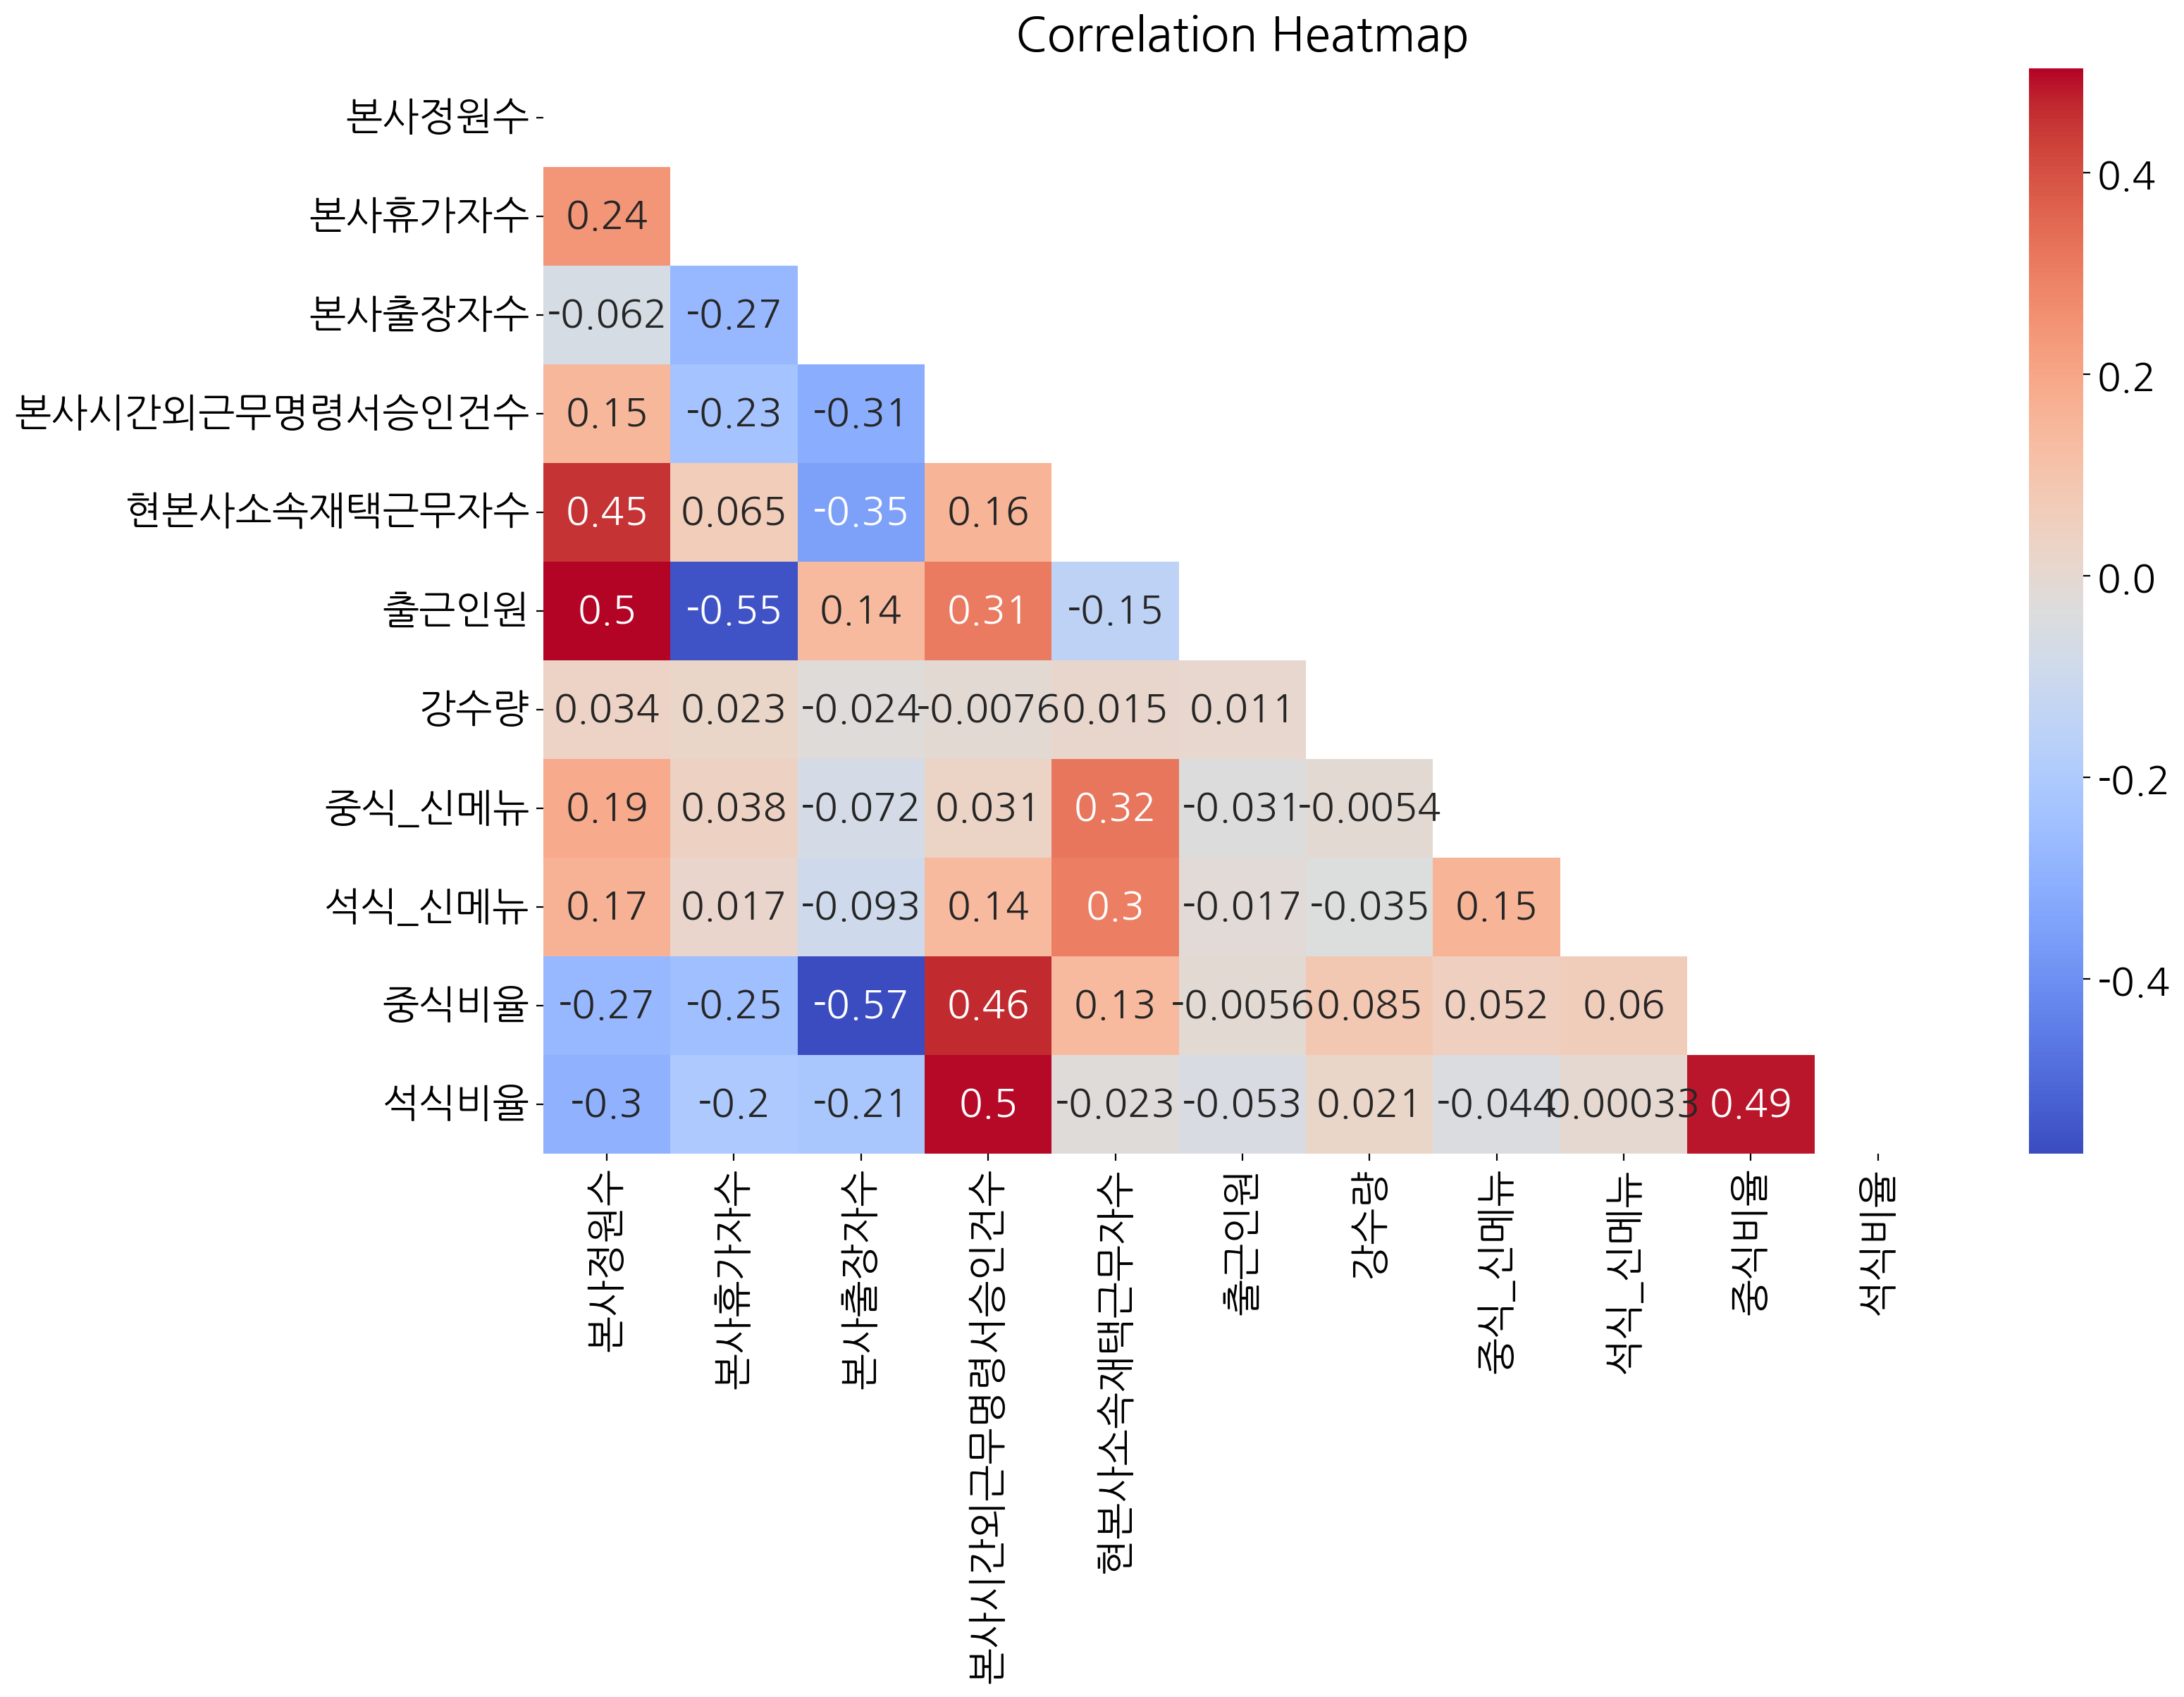

In [103]:
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(df, annot=True, cmap='coolwarm', mask=mask)
ax.set_title('Correlation Heatmap', pad = 10)
plt.show()

### info()

In [104]:
train6 = train[['일자', '연도', '월', '일', '요일',
                '출근인원', '본사시간외근무명령서승인건수',
                '강수량', '중식메뉴', '석식메뉴', '중식_신메뉴', '석식_신메뉴',
                '중식계', '석식계', '중식비율', '석식비율']]


In [105]:
# test6 = test[['일자', '연도', '월', '일', '요일', '출근인원', '강수량', '중식메뉴', '석식메뉴',
#        '중식_신메뉴', '석식_신메뉴']]

In [106]:
train6["일자"] = pd.to_datetime(train6["일자"])

C:\Users\user\AppData\Local\Temp\ipykernel_20852\1962341701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train6["일자"] = pd.to_datetime(train6["일자"])


In [107]:
train6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   연도              1205 non-null   int64         
 2   월               1205 non-null   int64         
 3   일               1205 non-null   int64         
 4   요일              1205 non-null   int64         
 5   출근인원            1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   강수량             1205 non-null   float64       
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식_신메뉴          1205 non-null   int32         
 11  석식_신메뉴          1205 non-null   int32         
 12  중식계             1205 non-null   int32         
 13  석식계             1205 non-null   int32         
 14  중식비율            1205 non-null   float64       
 15  석식비율

In [108]:
train6['중식비율'].describe()

count    1205.000000
mean        0.376458
std         0.085110
min         0.143649
25%         0.317741
50%         0.371933
75%         0.432010
max         0.597203
Name: 중식비율, dtype: float64

In [109]:
train6['석식비율'].describe()

count    1205.000000
mean        0.195460
std         0.058032
min         0.000000
25%         0.172010
50%         0.203690
75%         0.230567
max         0.380270
Name: 석식비율, dtype: float64

<AxesSubplot:>

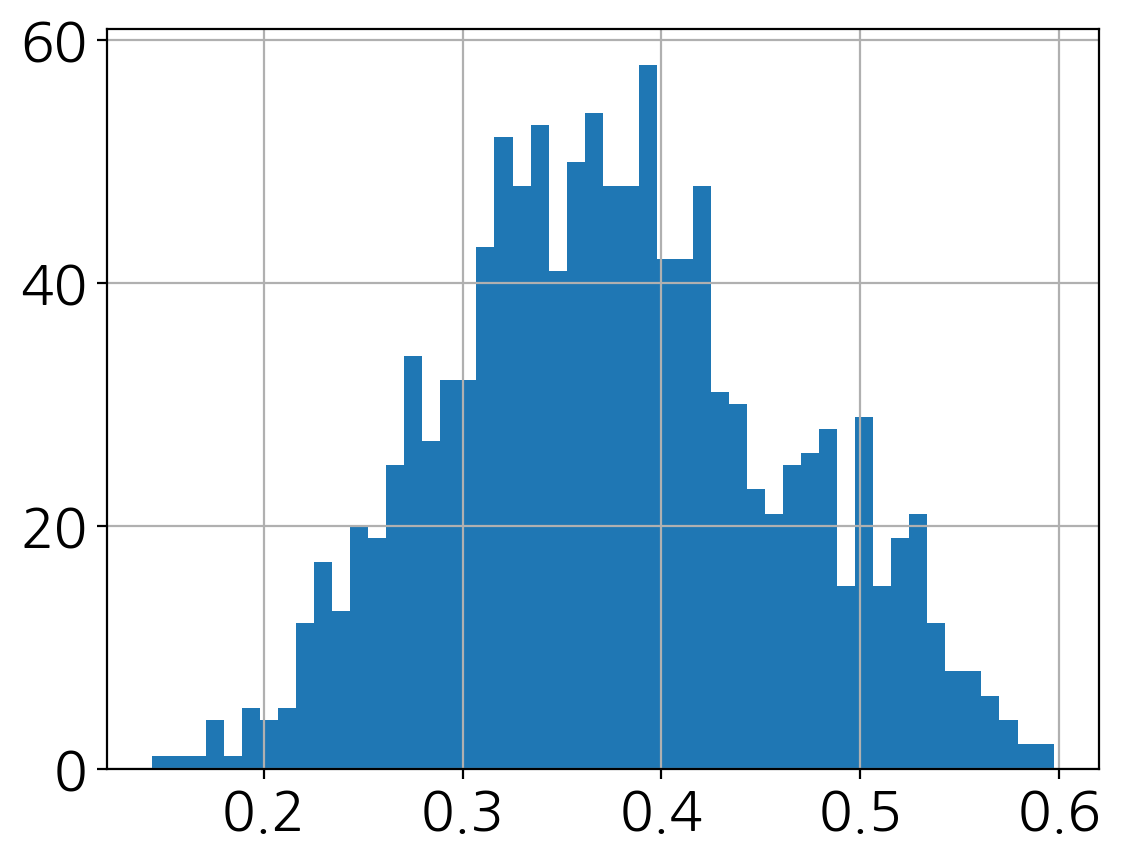

In [110]:
train6['중식비율'].hist(bins=50)

<AxesSubplot:>

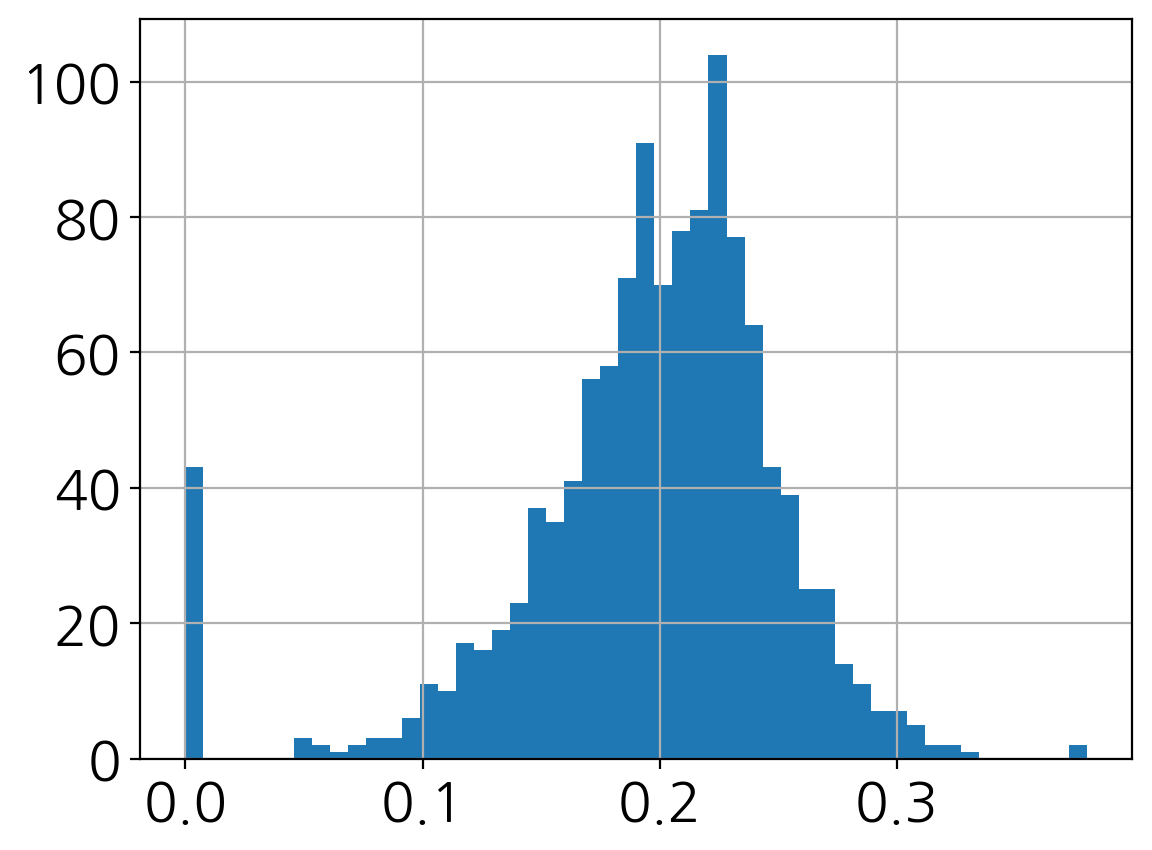

In [111]:
train6['석식비율'].hist(bins=50)

In [112]:
train6[train6['석식비율'] == 0]

,일자,연도,월,일,요일,출근인원,본사시간외근무명령서승인건수,강수량,중식메뉴,석식메뉴,중식_신메뉴,석식_신메뉴,중식계,석식계,중식비율,석식비율
204,2016-11-30,2016,11,30,3,2414,0,4.5,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,0,0,1109,0,0.459403,0.0
224,2016-12-28,2016,12,28,3,2314,0,0.0,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,0,0,767,0,0.331461,0.0
244,2017-01-25,2017,1,25,3,2415,0,0.0,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,0,0,720,0,0.298137,0.0
262,2017-02-22,2017,2,22,3,2305,0,30.1,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,0,0,1065,0,0.462039,0.0
281,2017-03-22,2017,3,22,3,2339,0,0.0,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,0,0,953,0,0.407439,0.0
306,2017-04-26,2017,4,26,3,2277,0,1.7,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,0,0,835,0,0.366711,0.0
327,2017-05-31,2017,5,31,3,2329,0,0.8,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,0,0,910,0,0.390726,0.0
346,2017-06-28,2017,6,28,3,2331,0,0.0,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,0,0,745,0,0.319605,0.0
366,2017-07-26,2017,7,26,3,2339,0,0.0,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,0,0,797,0,0.340744,0.0
392,2017-09-01,2017,9,1,5,2162,45,0.0,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,0,0,663,0,0.306660,0.0


In [113]:
train6[train6['석식비율'] == 0]['요일'].value_counts()

# 대부분 수요일 자기계발의 날

3    40
5     2
2     1
Name: 요일, dtype: int64

In [114]:
a = train6[train6['석식비율'] == 0]

a[a['요일'] == 2]     # 2019-12-31 석식 x
a[a['요일'] == 5]     # 2017-09-01, 2017-09-29 석식 x

,일자,연도,월,일,요일,출근인원,본사시간외근무명령서승인건수,강수량,중식메뉴,석식메뉴,중식_신메뉴,석식_신메뉴,중식계,석식계,중식비율,석식비율
392,2017-09-01,2017,9,1,5,2162,45,0.0,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,0,0,663,0,0.306660,0.0
412,2017-09-29,2017,9,29,5,2180,22,0.0,쌀밥/잡곡밥 (쌀:국내산) 미역국 쇠불고기/잡채 오징어숙회무침 미니케익/식혜 ...,*,0,0,760,0,0.348624,0.0


### 신메뉴별 평균 식사 인원

In [115]:
train6[['일자', '중식_신메뉴', '중식비율']]

,일자,중식_신메뉴,중식비율
0,2016-02-01,0,0.432736
1,2016-02-02,0,0.364592
2,2016-02-03,0,0.430021
3,2016-02-04,0,0.429513
4,2016-02-05,0,0.431839
...,...,...,...
1200,2021-01-20,0,0.471324
1201,2021-01-21,0,0.360329
1202,2021-01-22,0,0.265962
1203,2021-01-25,0,0.477880


In [116]:
q = train6['중식_신메뉴'].value_counts(1)*100
q

0    97.842324
1     2.157676
Name: 중식_신메뉴, dtype: float64

In [117]:
p = train6['석식_신메뉴'].value_counts(1)*100
p

0    98.257261
1     1.742739
Name: 석식_신메뉴, dtype: float64

* 신메뉴 비율
    - 중식: 2.15%
    - 석식: 1.74%
    
(비대칭)

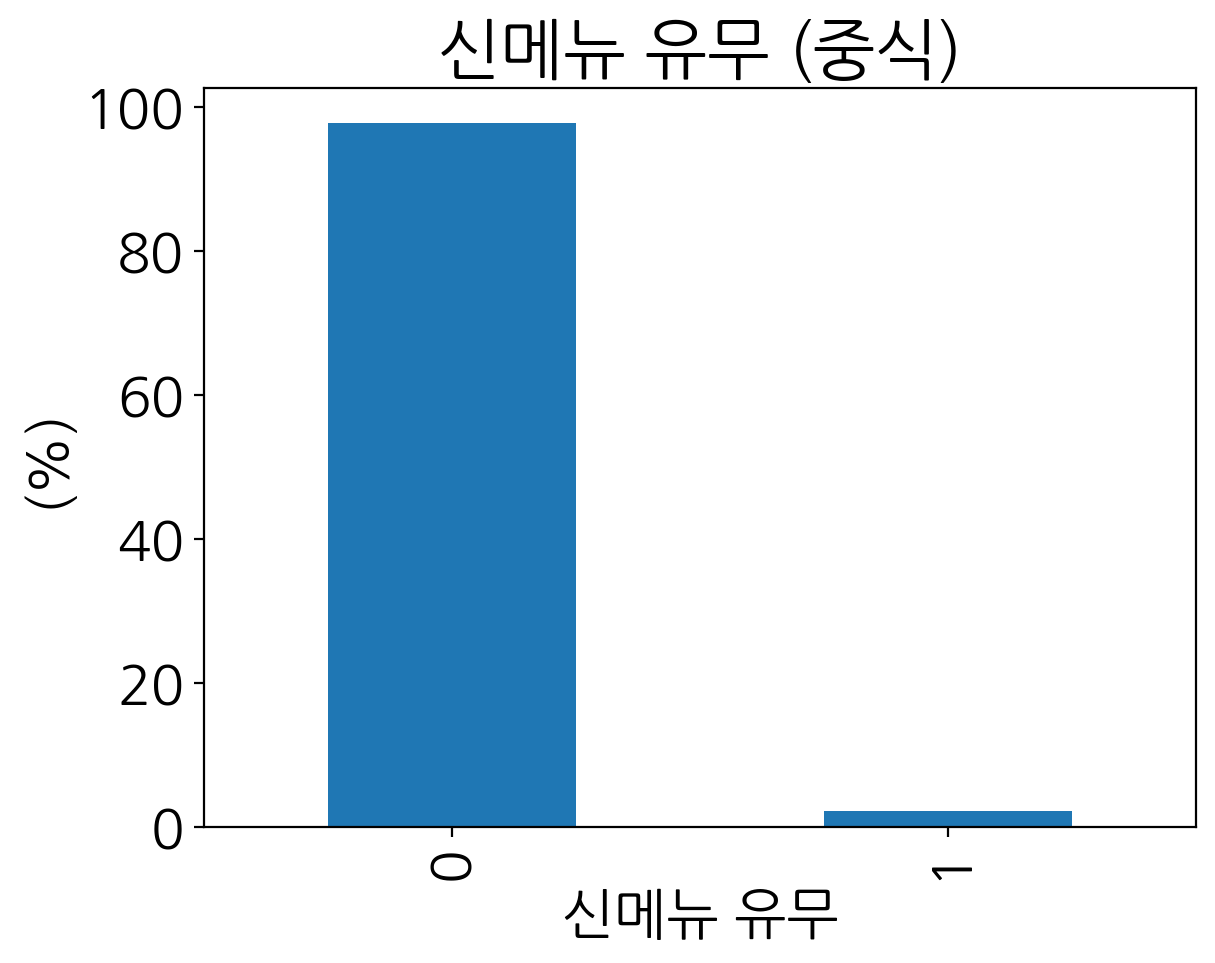

In [118]:
(q).plot(kind='bar', title='신메뉴 유무 (중식)')
plt.xlabel('신메뉴 유무')
plt.ylabel('(%)')
plt.show()

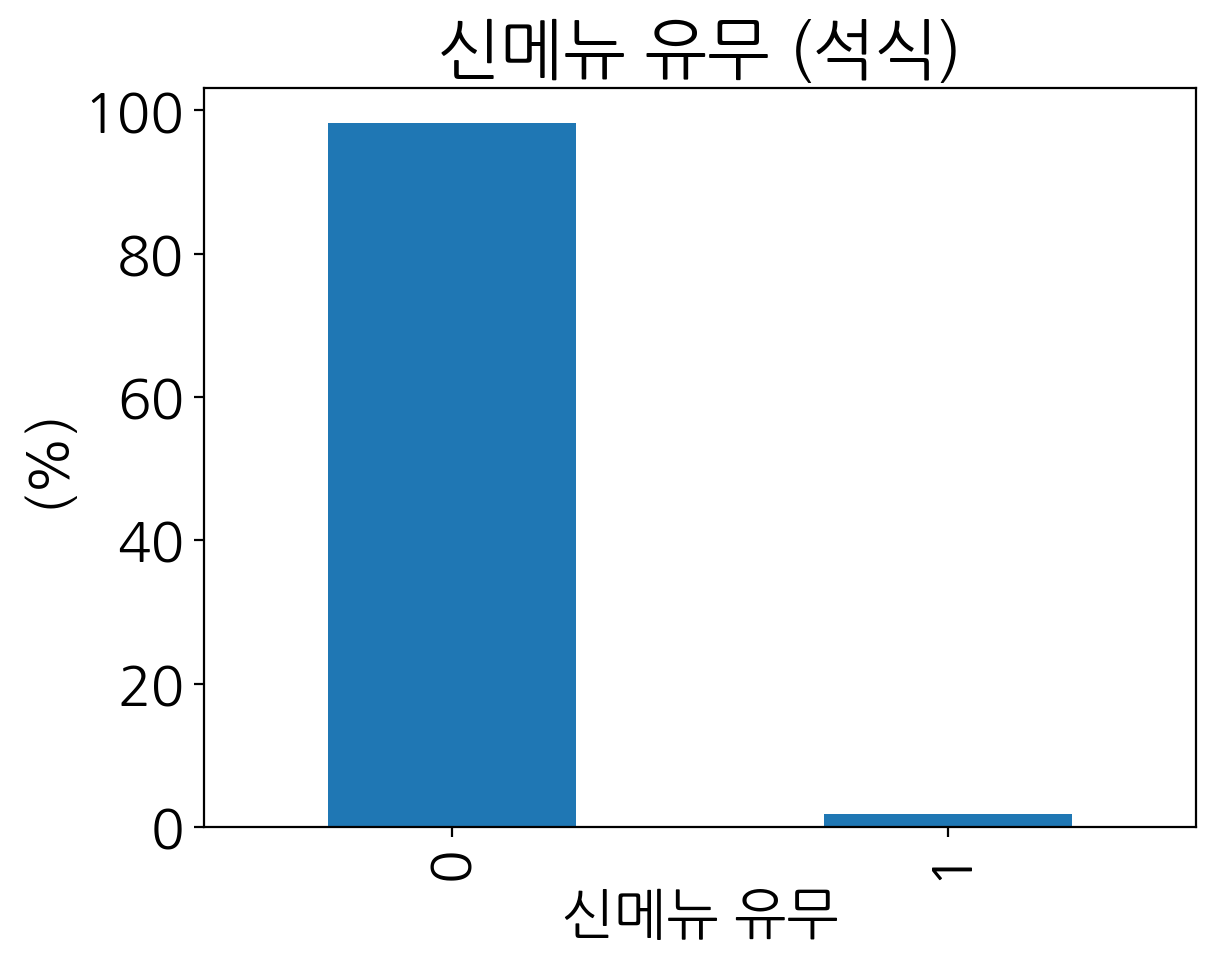

In [119]:
(p).plot(kind='bar', title='신메뉴 유무 (석식)')
plt.xlabel('신메뉴 유무')
plt.ylabel('(%)')
plt.show()

In [120]:
# 신메뉴 유무별 평균 식사 인원 차이

In [121]:
w = train6.groupby('중식_신메뉴')['중식비율'].mean()
w


중식_신메뉴
0    0.375798
1    0.406413
Name: 중식비율, dtype: float64

In [122]:
e = train6.groupby('석식_신메뉴')['석식비율'].mean()
e

석식_신메뉴
0    0.195457
1    0.195602
Name: 석식비율, dtype: float64

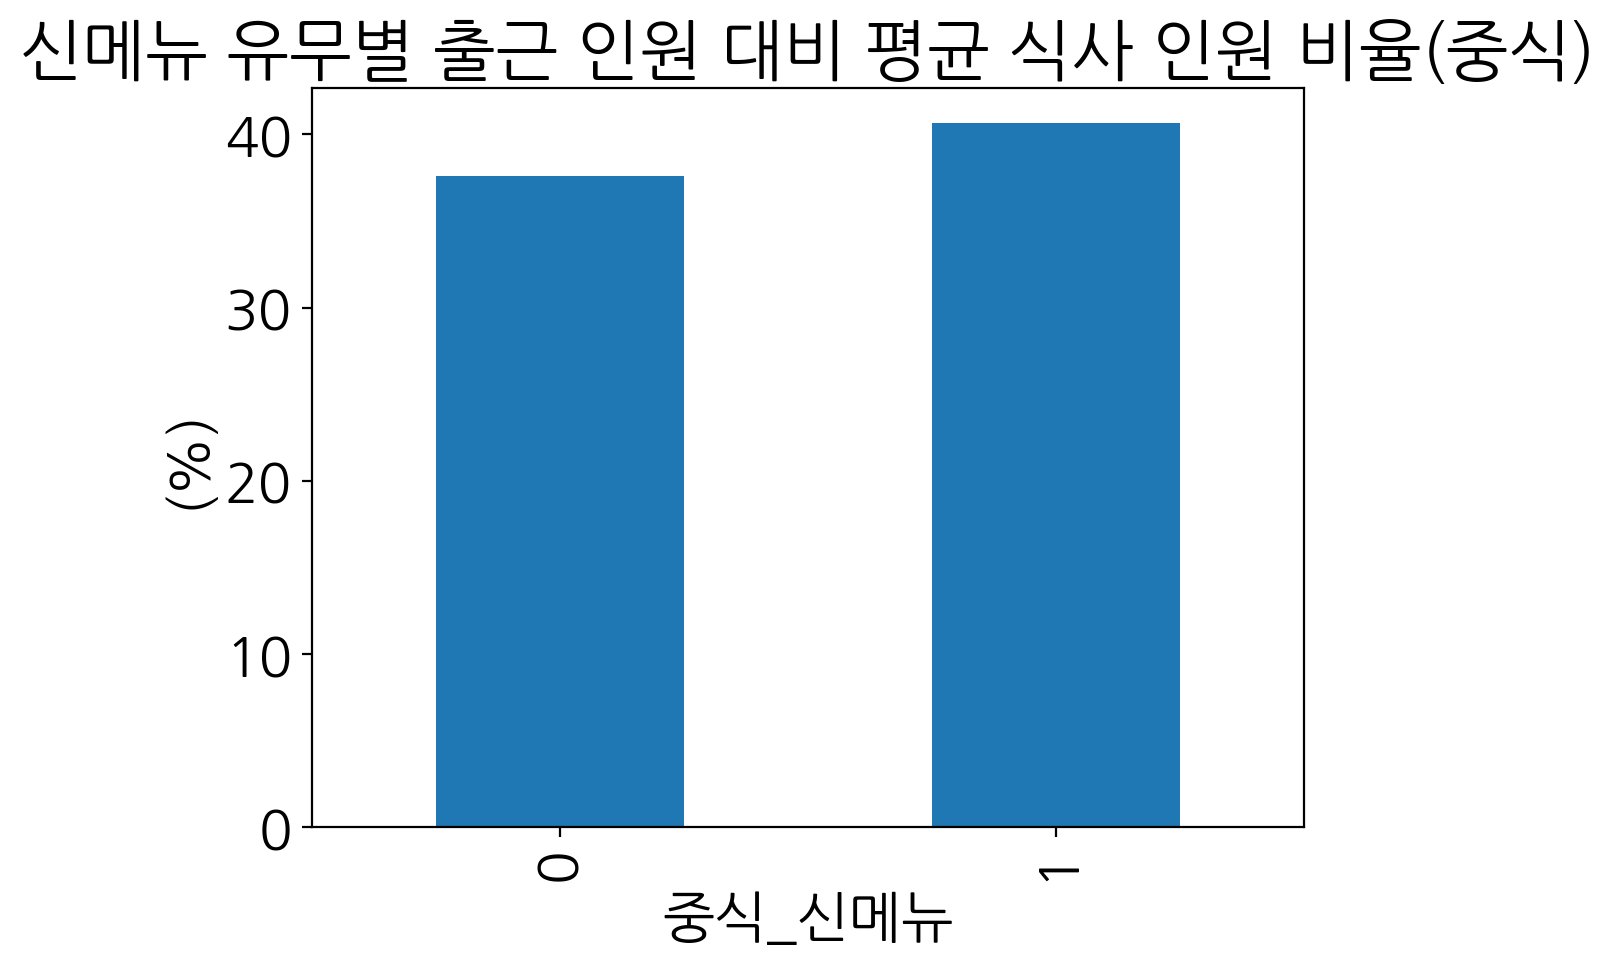

In [123]:
(w*100).plot(kind='bar', title='신메뉴 유무별 출근 인원 대비 평균 식사 인원 비율(중식)')
plt.ylabel('(%)')
plt.show()

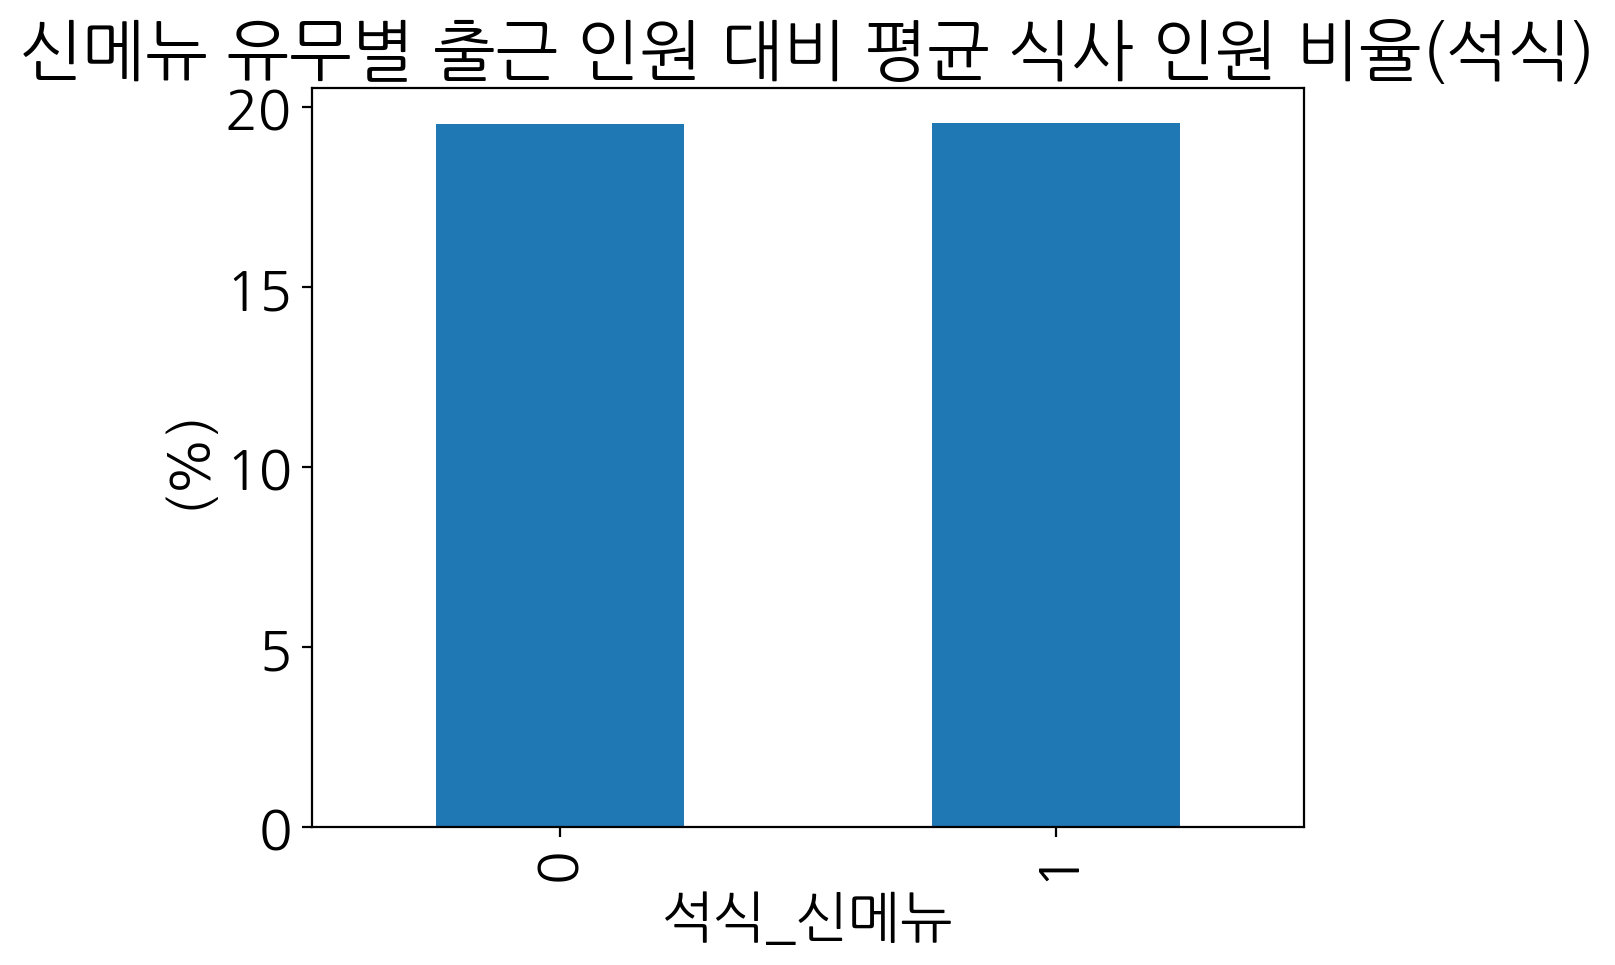

In [124]:
(e*100).plot(kind='bar', title='신메뉴 유무별 출근 인원 대비 평균 식사 인원 비율(석식)')
plt.ylabel('(%)')
plt.show()

In [125]:
# 상관관계

train6[['중식_신메뉴', '석식_신메뉴', '중식비율', '석식비율']].corr()

,중식_신메뉴,석식_신메뉴,중식비율,석식비율
중식_신메뉴,1.000000,0.154812,0.052287,-0.044216
석식_신메뉴,0.154812,1.000000,0.060248,0.000327
중식비율,0.052287,0.060248,1.000000,0.485553
석식비율,-0.044216,0.000327,0.485553,1.000000


<AxesSubplot:>

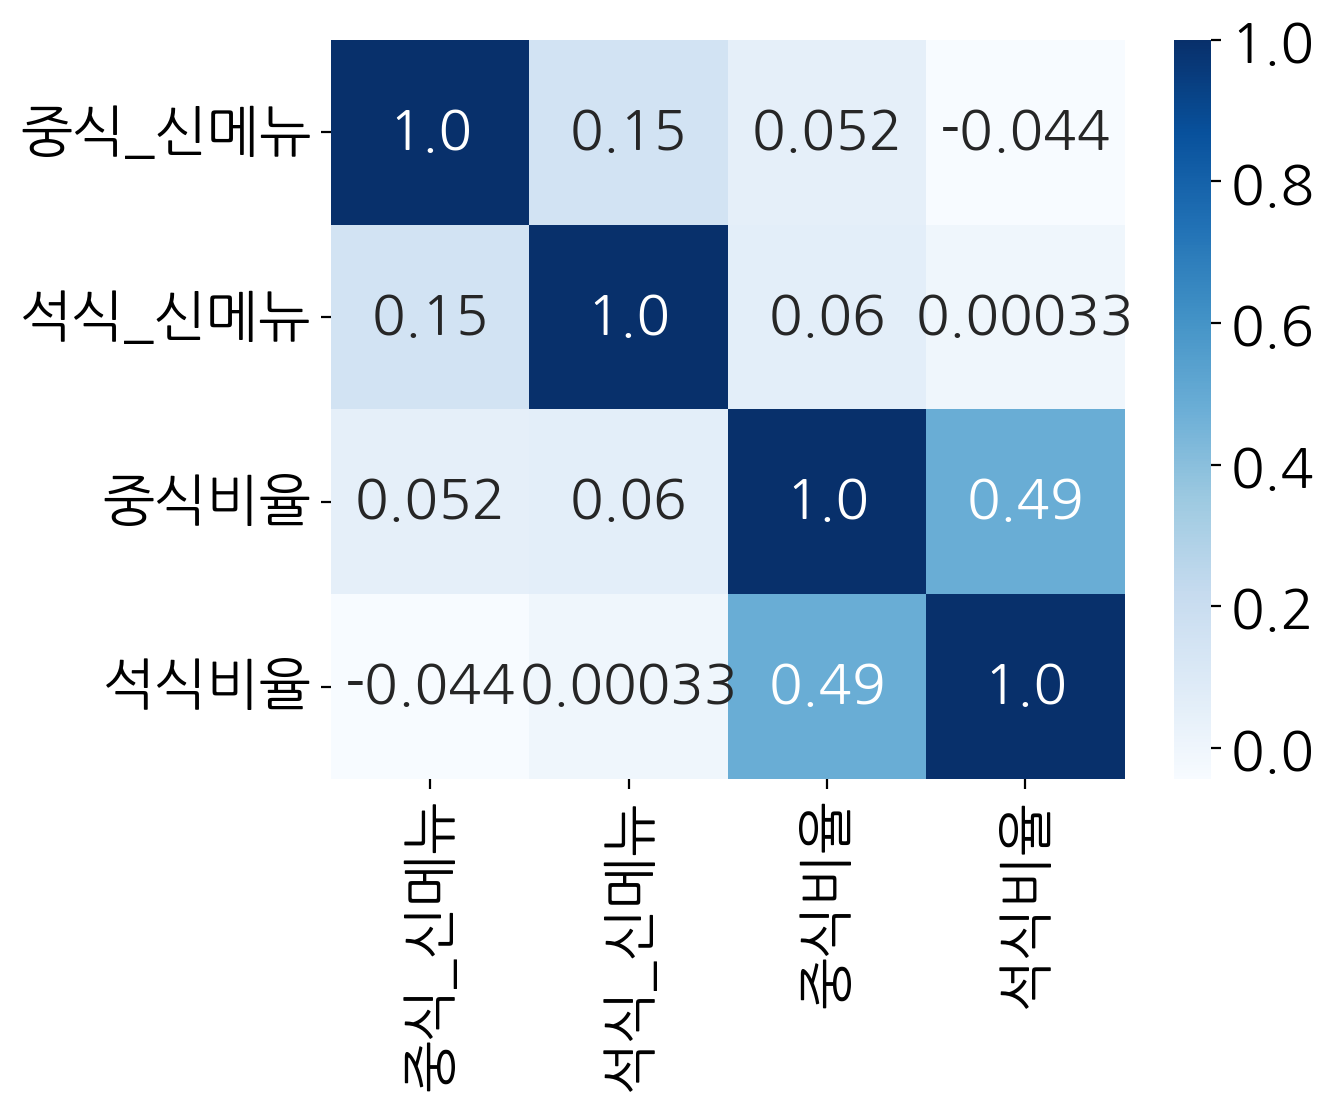

In [126]:
sns.heatmap(train6[['중식_신메뉴', '석식_신메뉴', '중식비율', '석식비율']].corr(), annot=True, cmap='Blues', fmt='.2')

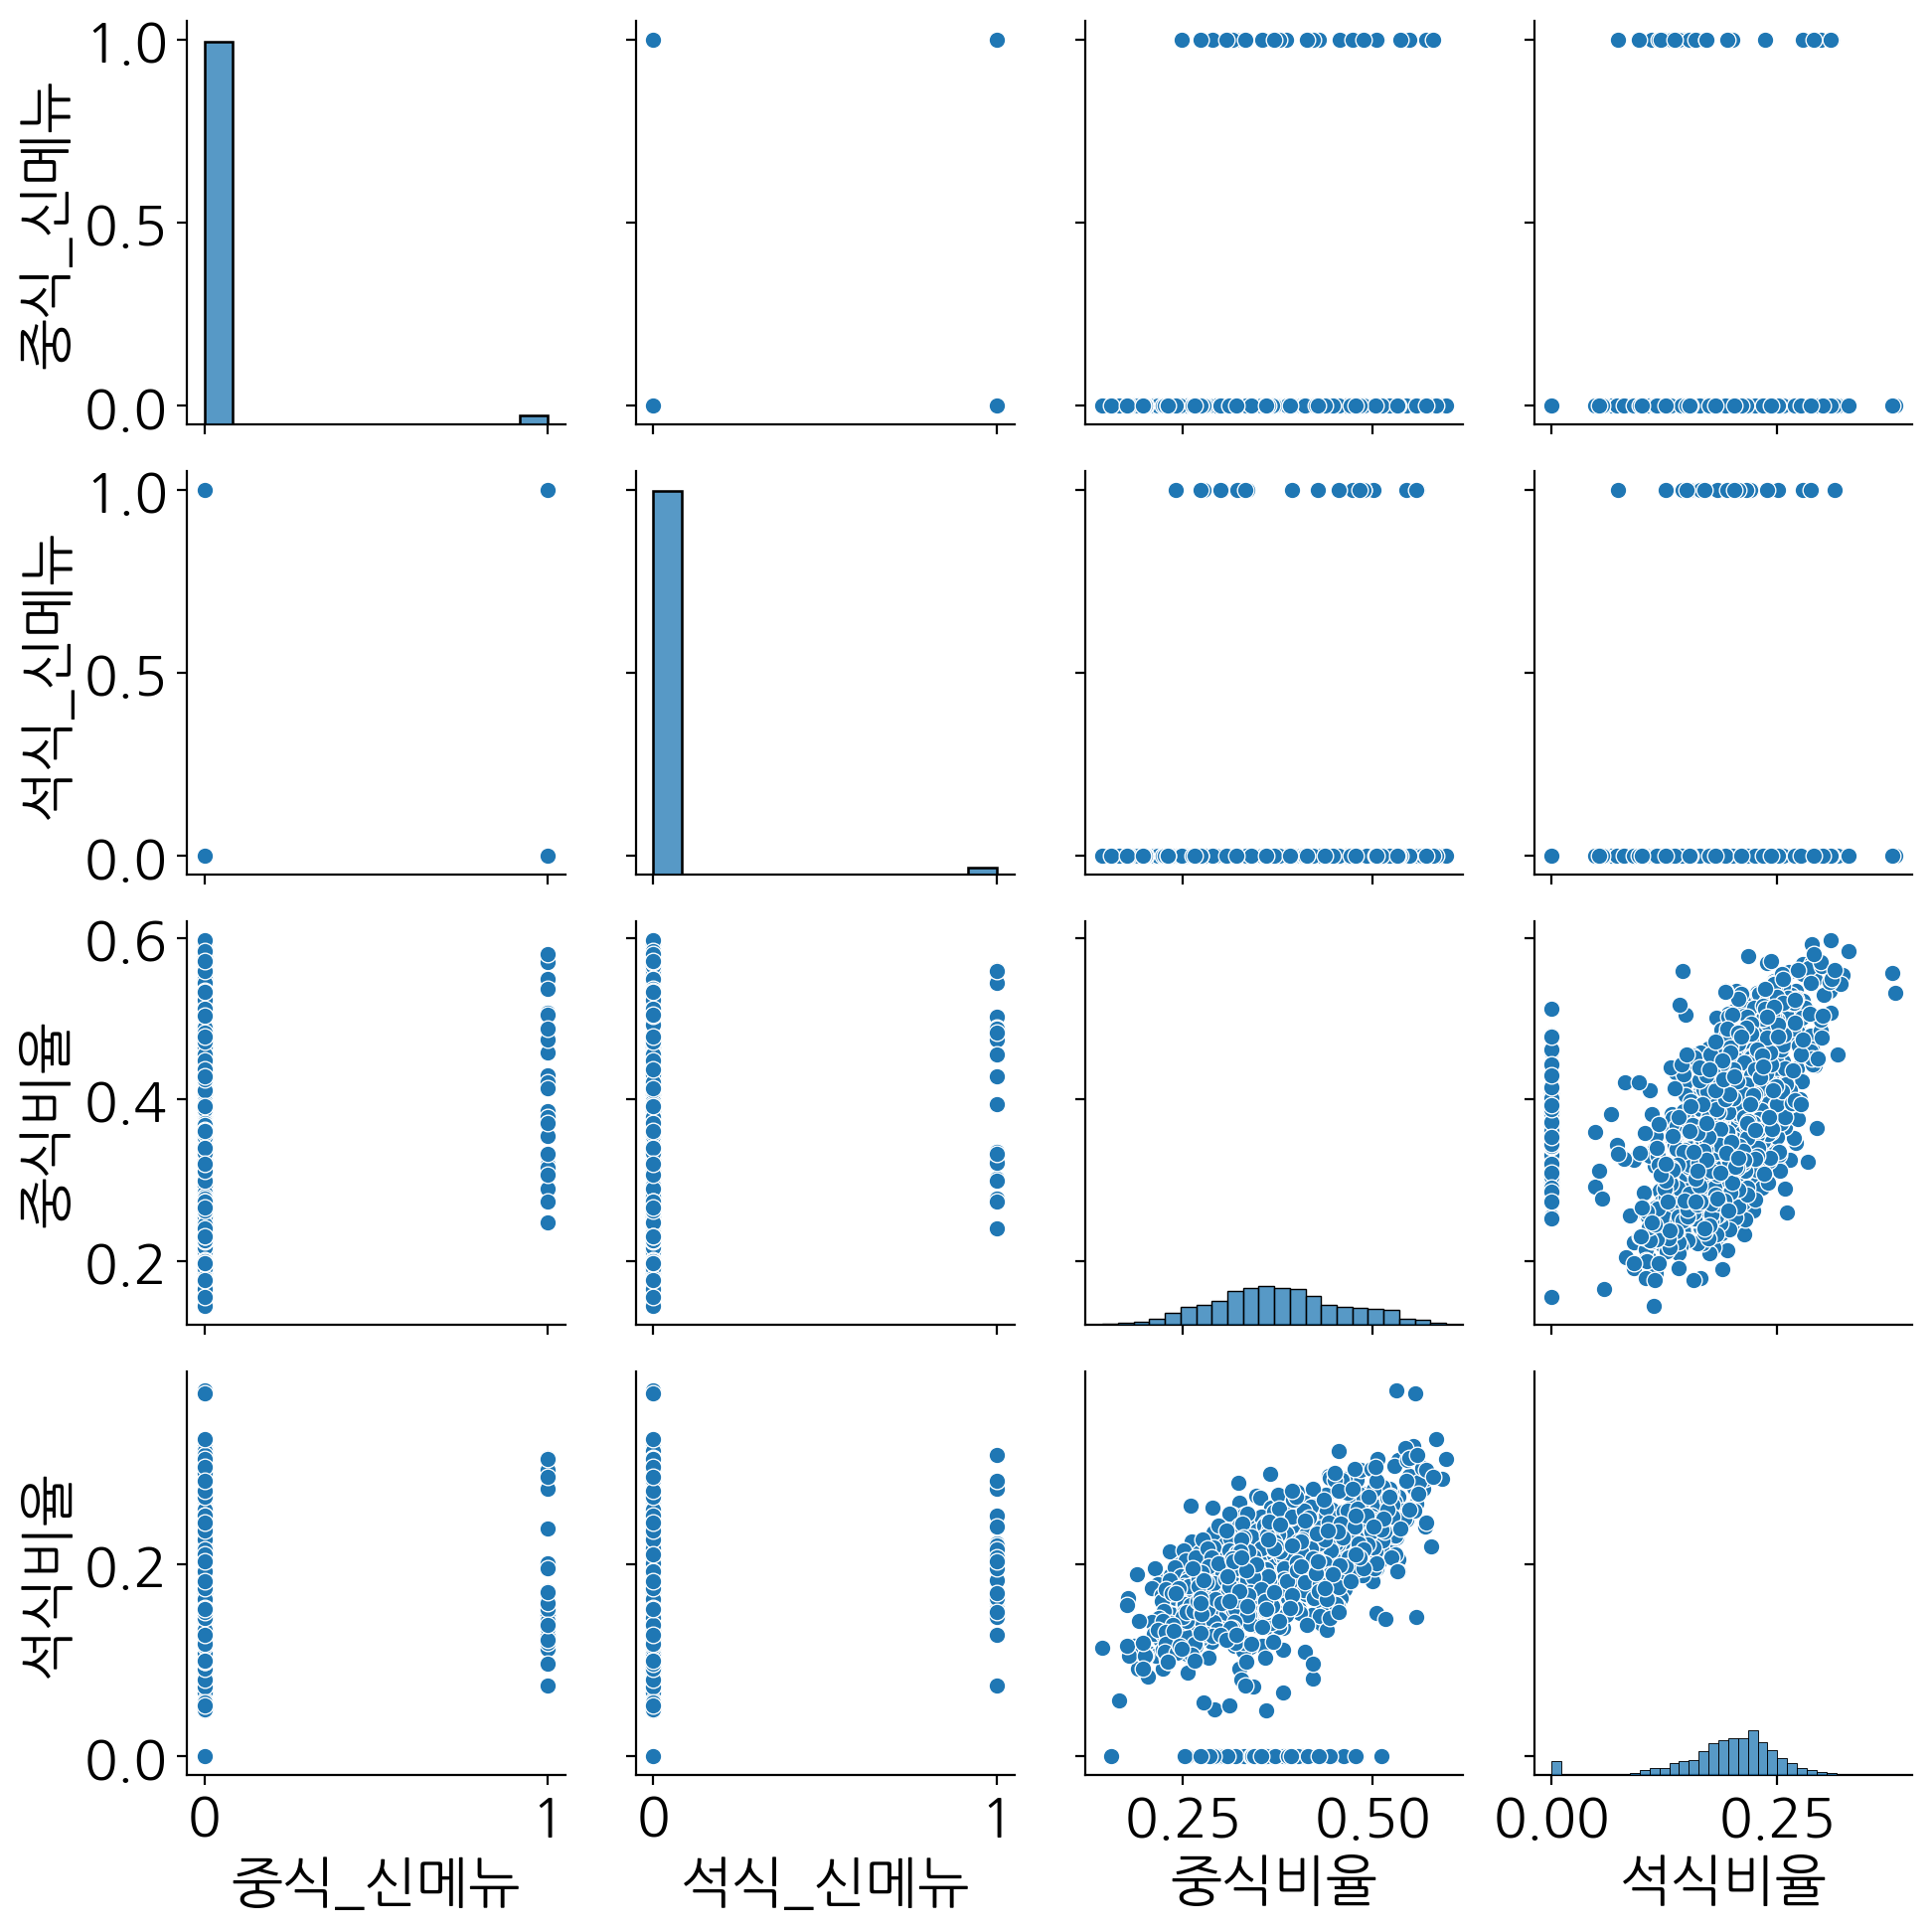

In [127]:
sns.pairplot(train6[['중식_신메뉴', '석식_신메뉴', '중식비율', '석식비율']])

### 강수량

In [128]:
train6['강수량'].describe()

# 대부분 비가 오지 않은 날

count    1205.000000
mean        3.919502
std        13.004174
min         0.000000
25%         0.000000
50%         0.000000
75%         0.100000
max       139.600000
Name: 강수량, dtype: float64

In [129]:
train6['강수량'].value_counts()

0.0     896
0.1      14
0.3      10
0.2      10
0.5       9
       ... 
11.6      1
8.1       1
20.2      1
28.8      1
20.4      1
Name: 강수량, Length: 175, dtype: int64

<AxesSubplot:>

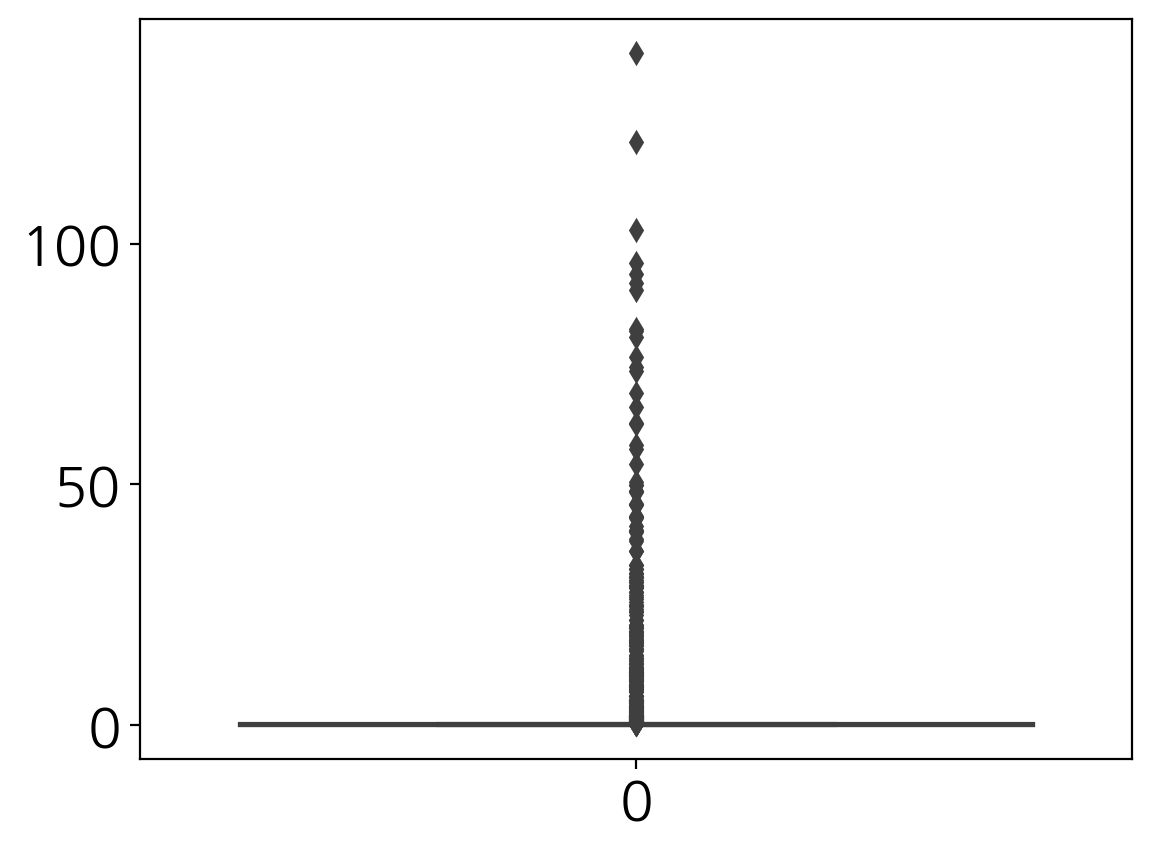

In [130]:
sns.boxplot(data=train6['강수량'])

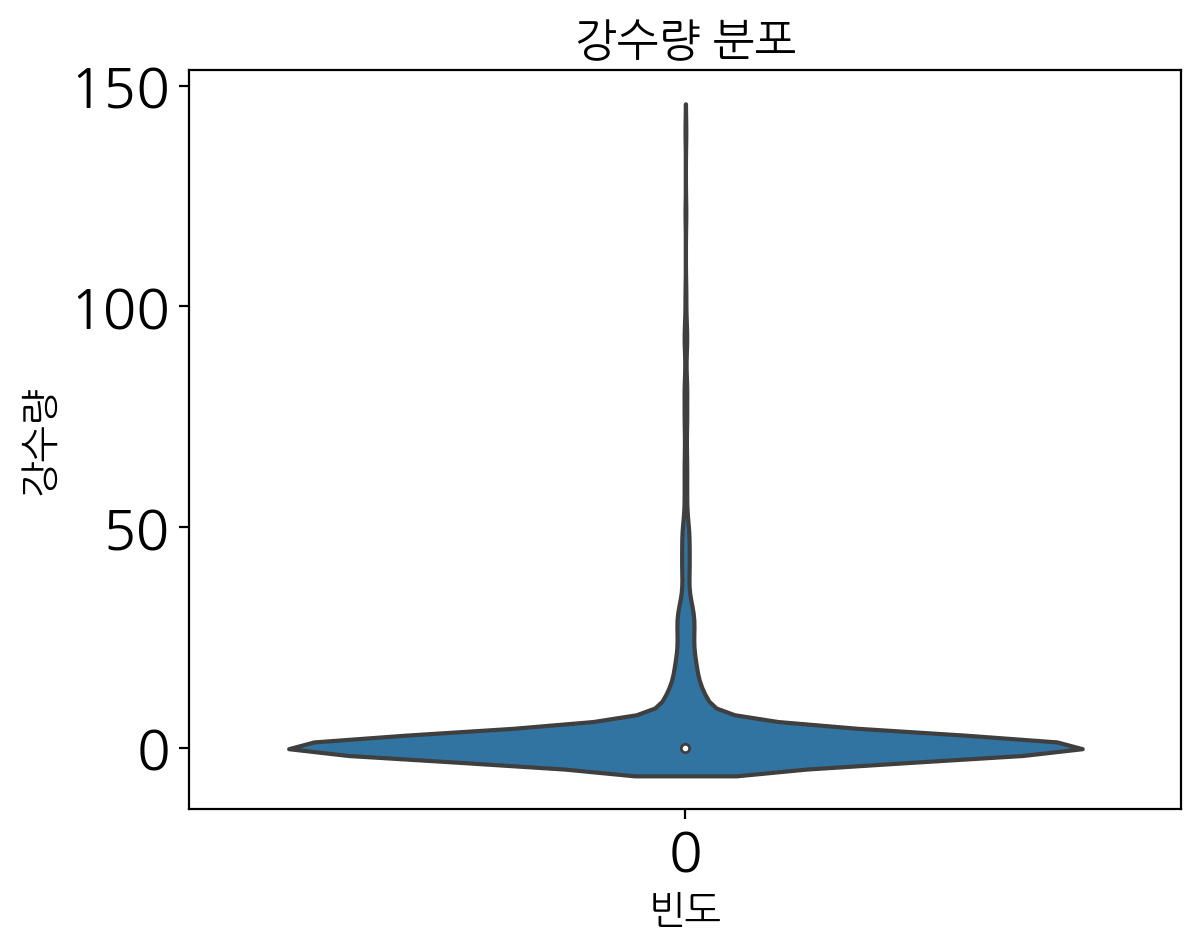

In [131]:
sns.violinplot(data=train6['강수량'])

plt.title('강수량 분포', fontsize=16)
plt.ylabel('강수량', fontsize=14)
plt.xlabel('빈도', fontsize=14)
plt.show()

In [134]:
# 강수량을 1mm을 기준으로 구분

train6['강수여부'] = train6['강수량'].apply(lambda x: 1 if x >= 1 else 0)
train6.head()

C:\Users\user\AppData\Local\Temp\ipykernel_20852\4196676622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train6['강수여부'] = train6['강수량'].apply(lambda x: 1 if x >= 1 else 0)


,일자,연도,월,일,요일,출근인원,본사시간외근무명령서승인건수,강수량,중식메뉴,석식메뉴,중식_신메뉴,석식_신메뉴,중식계,석식계,중식비율,석식비율,강수여부
0,2016-02-01,2016,2,1,1,2401,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",0,0,1039,331,0.432736,0.137859,0
1,2016-02-02,2016,2,2,2,2378,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",0,0,867,560,0.364592,0.235492,0
2,2016-02-03,2016,2,3,3,2365,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",0,0,1017,573,0.430021,0.242283,0
3,2016-02-04,2016,2,4,4,2277,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",0,0,978,525,0.429513,0.230567,0
4,2016-02-05,2016,2,5,5,2142,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",0,0,925,330,0.431839,0.154062,0


In [135]:
train6['강수여부'].value_counts()

0    963
1    242
Name: 강수여부, dtype: int64

In [136]:
a = train6.groupby('강수여부')['중식비율'].mean()
a

강수여부
0    0.374249
1    0.385251
Name: 중식비율, dtype: float64

In [137]:
b = train6.groupby('강수여부')['석식비율'].mean()
b

강수여부
0    0.195484
1    0.195365
Name: 석식비율, dtype: float64

Text(0, 0.5, '(%)')

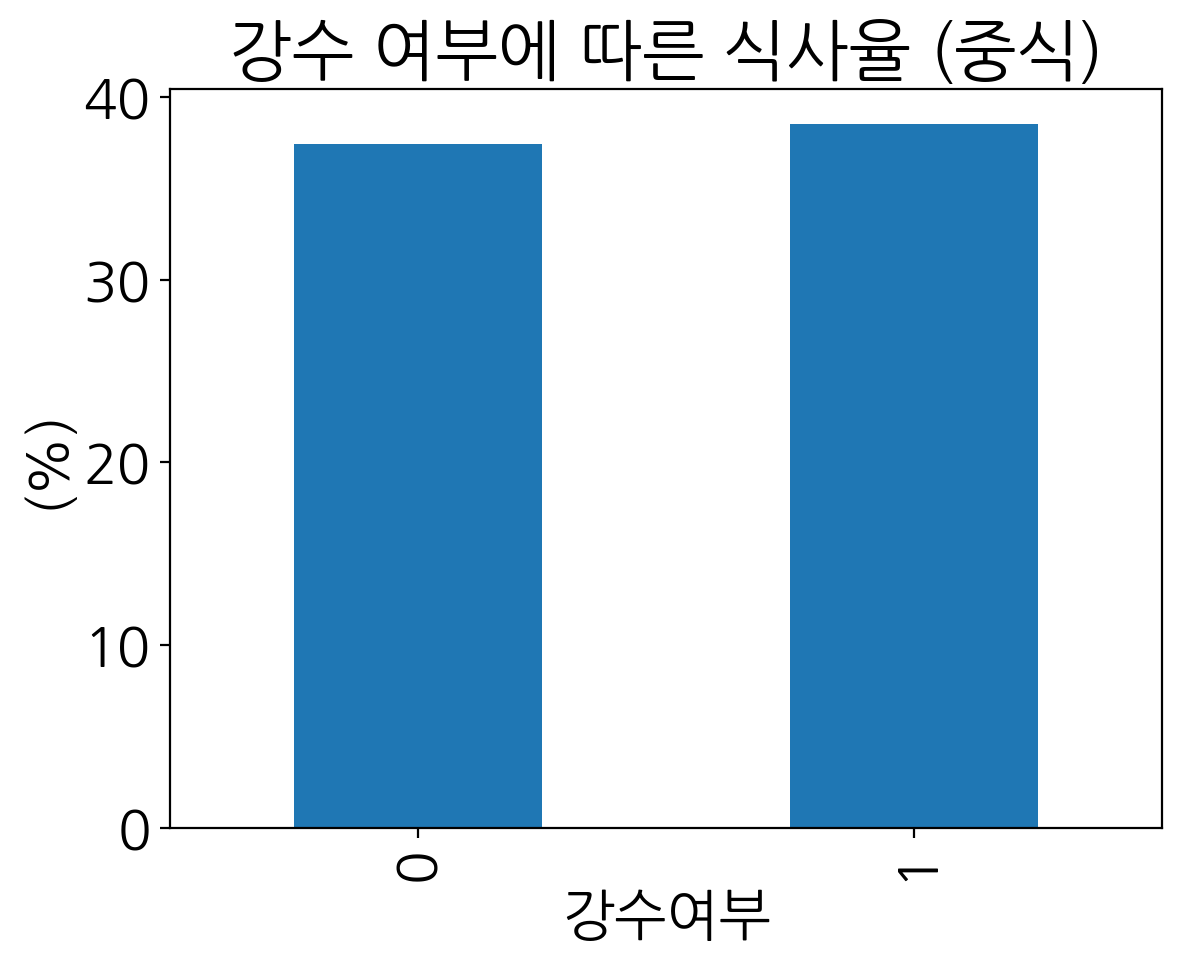

In [139]:
(a*100).plot(kind='bar', title='강수 여부에 따른 식사율 (중식)')
plt.ylabel('(%)')

Text(0, 0.5, '(%)')

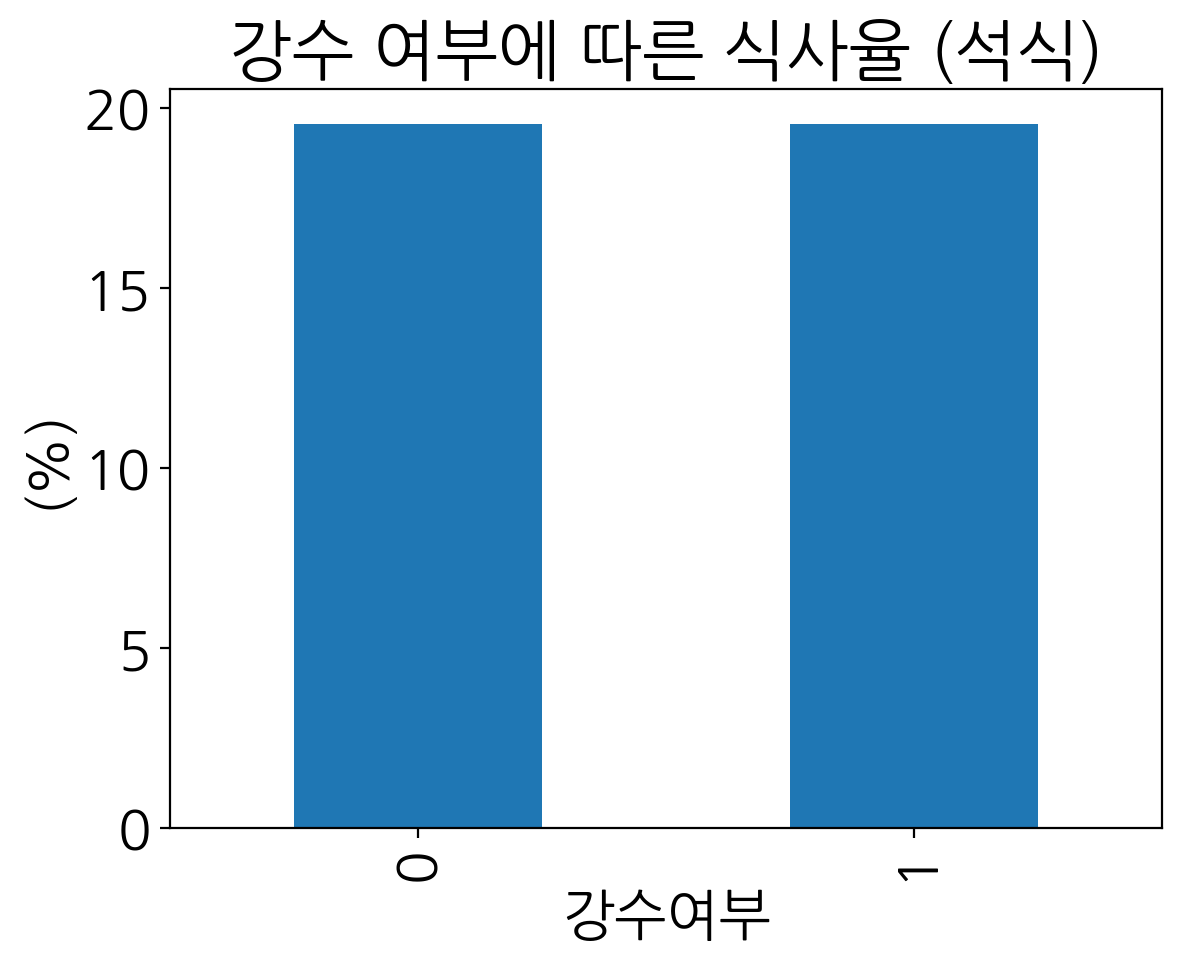

In [140]:
(b*100).plot(kind='bar', title='강수 여부에 따른 식사율 (석식)')
plt.ylabel('(%)')

강수 여부를 1mm로 구분하였을 때 중식 비율은, 강수가 아닐 때 37%, 강수일 때 38%로 나타남.

In [553]:
train6['강수여부'] = train6['강수량'].apply(lambda x: 1 if x >= 10 else 0)
train6[train6['강수여부'] == 1]

C:\Users\user\AppData\Local\Temp\ipykernel_24820\2772023204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train6['강수여부'] = train6['강수량'].apply(lambda x: 1 if x >= 10 else 0)


,일자,연도,월,일,요일,출근인원,본사시간외근무명령서승인건수,강수량,중식메뉴,석식메뉴,중식_신메뉴,석식_신메뉴,중식계,석식계,중식비율,석식비율,강수여부
6,2016-02-12,2016,2,12,5,2056,93,62.8,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",0,0,909,598,0.442121,0.290856,1
20,2016-03-04,2016,3,4,5,2294,79,36.1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 부대찌개 가자미튀김 메추리알조림 열무된장나...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어국 미트볼조림 옥수수전 부추생채 포...",0,0,837,673,0.364865,0.293374,1
30,2016-03-18,2016,3,18,5,2229,57,27.6,쌀밥/잡곡밥 (쌀:국내산) 시금치국 훈제오리구이 연근땅콩조림 쌈무/부추생채 ...,쌀밥/잡곡밥 (쌀:국내산) 닭곰탕 (닭고기:국내산) 임연수찜 어묵곤약볶음 돌나물초...,0,0,757,521,0.339614,0.233737,1
43,2016-04-06,2016,4,6,3,2357,0,26.1,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 올갱이아욱국 제육볶음 두부조림 모둠쌈*쌈장...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 매운버섯국 찜닭 탕평채 청경채생채 포기김...",0,0,876,492,0.371659,0.208740,1
44,2016-04-07,2016,4,7,4,2338,339,28.7,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 어묵국 매운돼지갈비찜 해물파전 무생채 포...","김밥 (쌀,현미흑미:국내산) 우동 야채튀김 조각사과 오복지 포기김치 (배추,...",0,0,853,524,0.364842,0.224123,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2020-09-09,2020,9,9,3,2426,3,10.8,쌀밥/흑미밥/찰현미밥 홍합살미역국 수육*새우젓*쌈장 매콤볼어묵볶음 와사비무쌈 포기김...,흑미밥 동태매운탕 궁중떡볶이 해초레몬무침 청경채나물 포기김치,0,0,965,374,0.397774,0.154163,1
1117,2020-09-10,2020,9,10,4,2376,600,10.5,쌀밥/수수밥/찰현미밥 돈육김치찌개 수완왕갈비맛통닭 콩나물볶음 미나리초장무침 포기김치...,충무김밥 우동장국 오징어무침 채소튀김*장 수제무말랭이무침 포기김치/요구르트,0,0,881,514,0.370791,0.216330,1
1141,2020-10-21,2020,10,21,3,2502,6,27.6,쌀밥/흑미밥/찰현미밥 미역미소시루국 (New)연어스테이크 차돌비빔국수 토마토계란볶음...,흑미밥 고추장찌개 소불고기 진미채무말랭이무침 햄감자볶음 포기김치/열무김치볶음,1,0,887,336,0.354516,0.134293,1
1162,2020-11-19,2020,11,19,4,2490,541,20.4,쌀밥/검정콩밥/찰현미밥 얼갈이된장국 쇠고기당면볶음 가자미유린기 물미역*초장 포기김치...,꼬치어묵매운탕 떡갈비주먹밥/추가밥 채소볶음우동 콘샐러드 단무지무침 포기김치,0,0,653,486,0.262249,0.195181,1


In [554]:
train6.groupby('강수여부')['중식비율'].mean()

강수여부
0    0.374444
1    0.393113
Name: 중식비율, dtype: float64

In [555]:
train6.groupby('강수여부')['석식비율'].mean()

강수여부
0    0.195374
1    0.196174
Name: 석식비율, dtype: float64

10mm로 구분하였을 때 중식 비율은 강수가 아닐 때 37%, 강수일 때 39%로 나타남

In [556]:
# 상관관계

train6[['강수량', '강수여부', '중식비율', '석식비율']].corr()

,강수량,강수여부,중식비율,석식비율
강수량,1.000000,0.768305,0.085308,0.021232
강수여부,0.768305,1.000000,0.068079,0.004282
중식비율,0.085308,0.068079,1.000000,0.485553
석식비율,0.021232,0.004282,0.485553,1.000000


<AxesSubplot:>

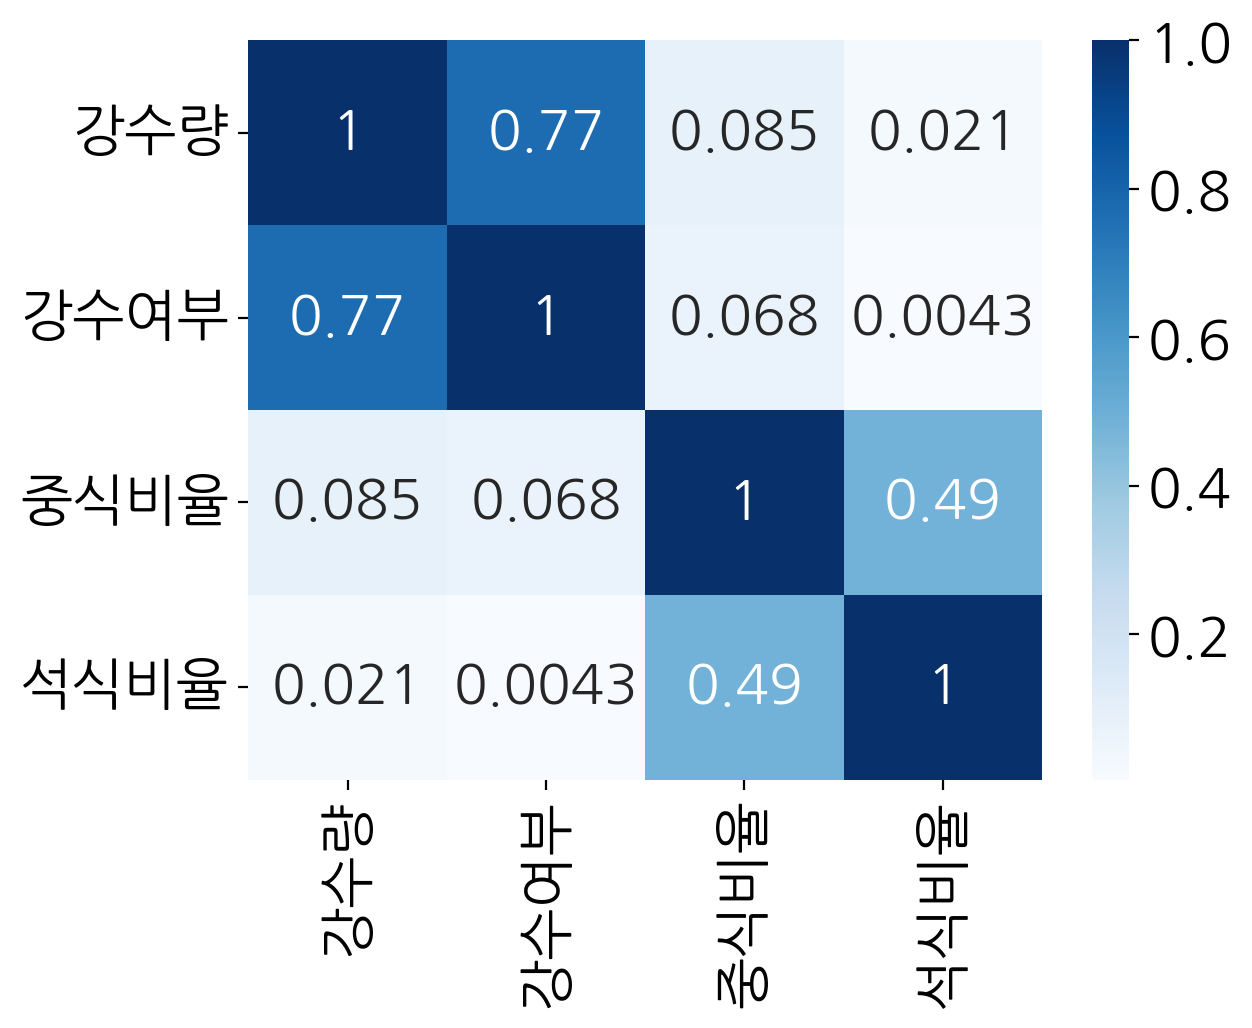

In [557]:
sns.heatmap(train6[['강수량', '강수여부', '중식비율', '석식비율']].corr(), annot=True, cmap='Blues')

중식비율과의 상관관계가 강수량은 0.085, 강수여부는 0.068로 나타남

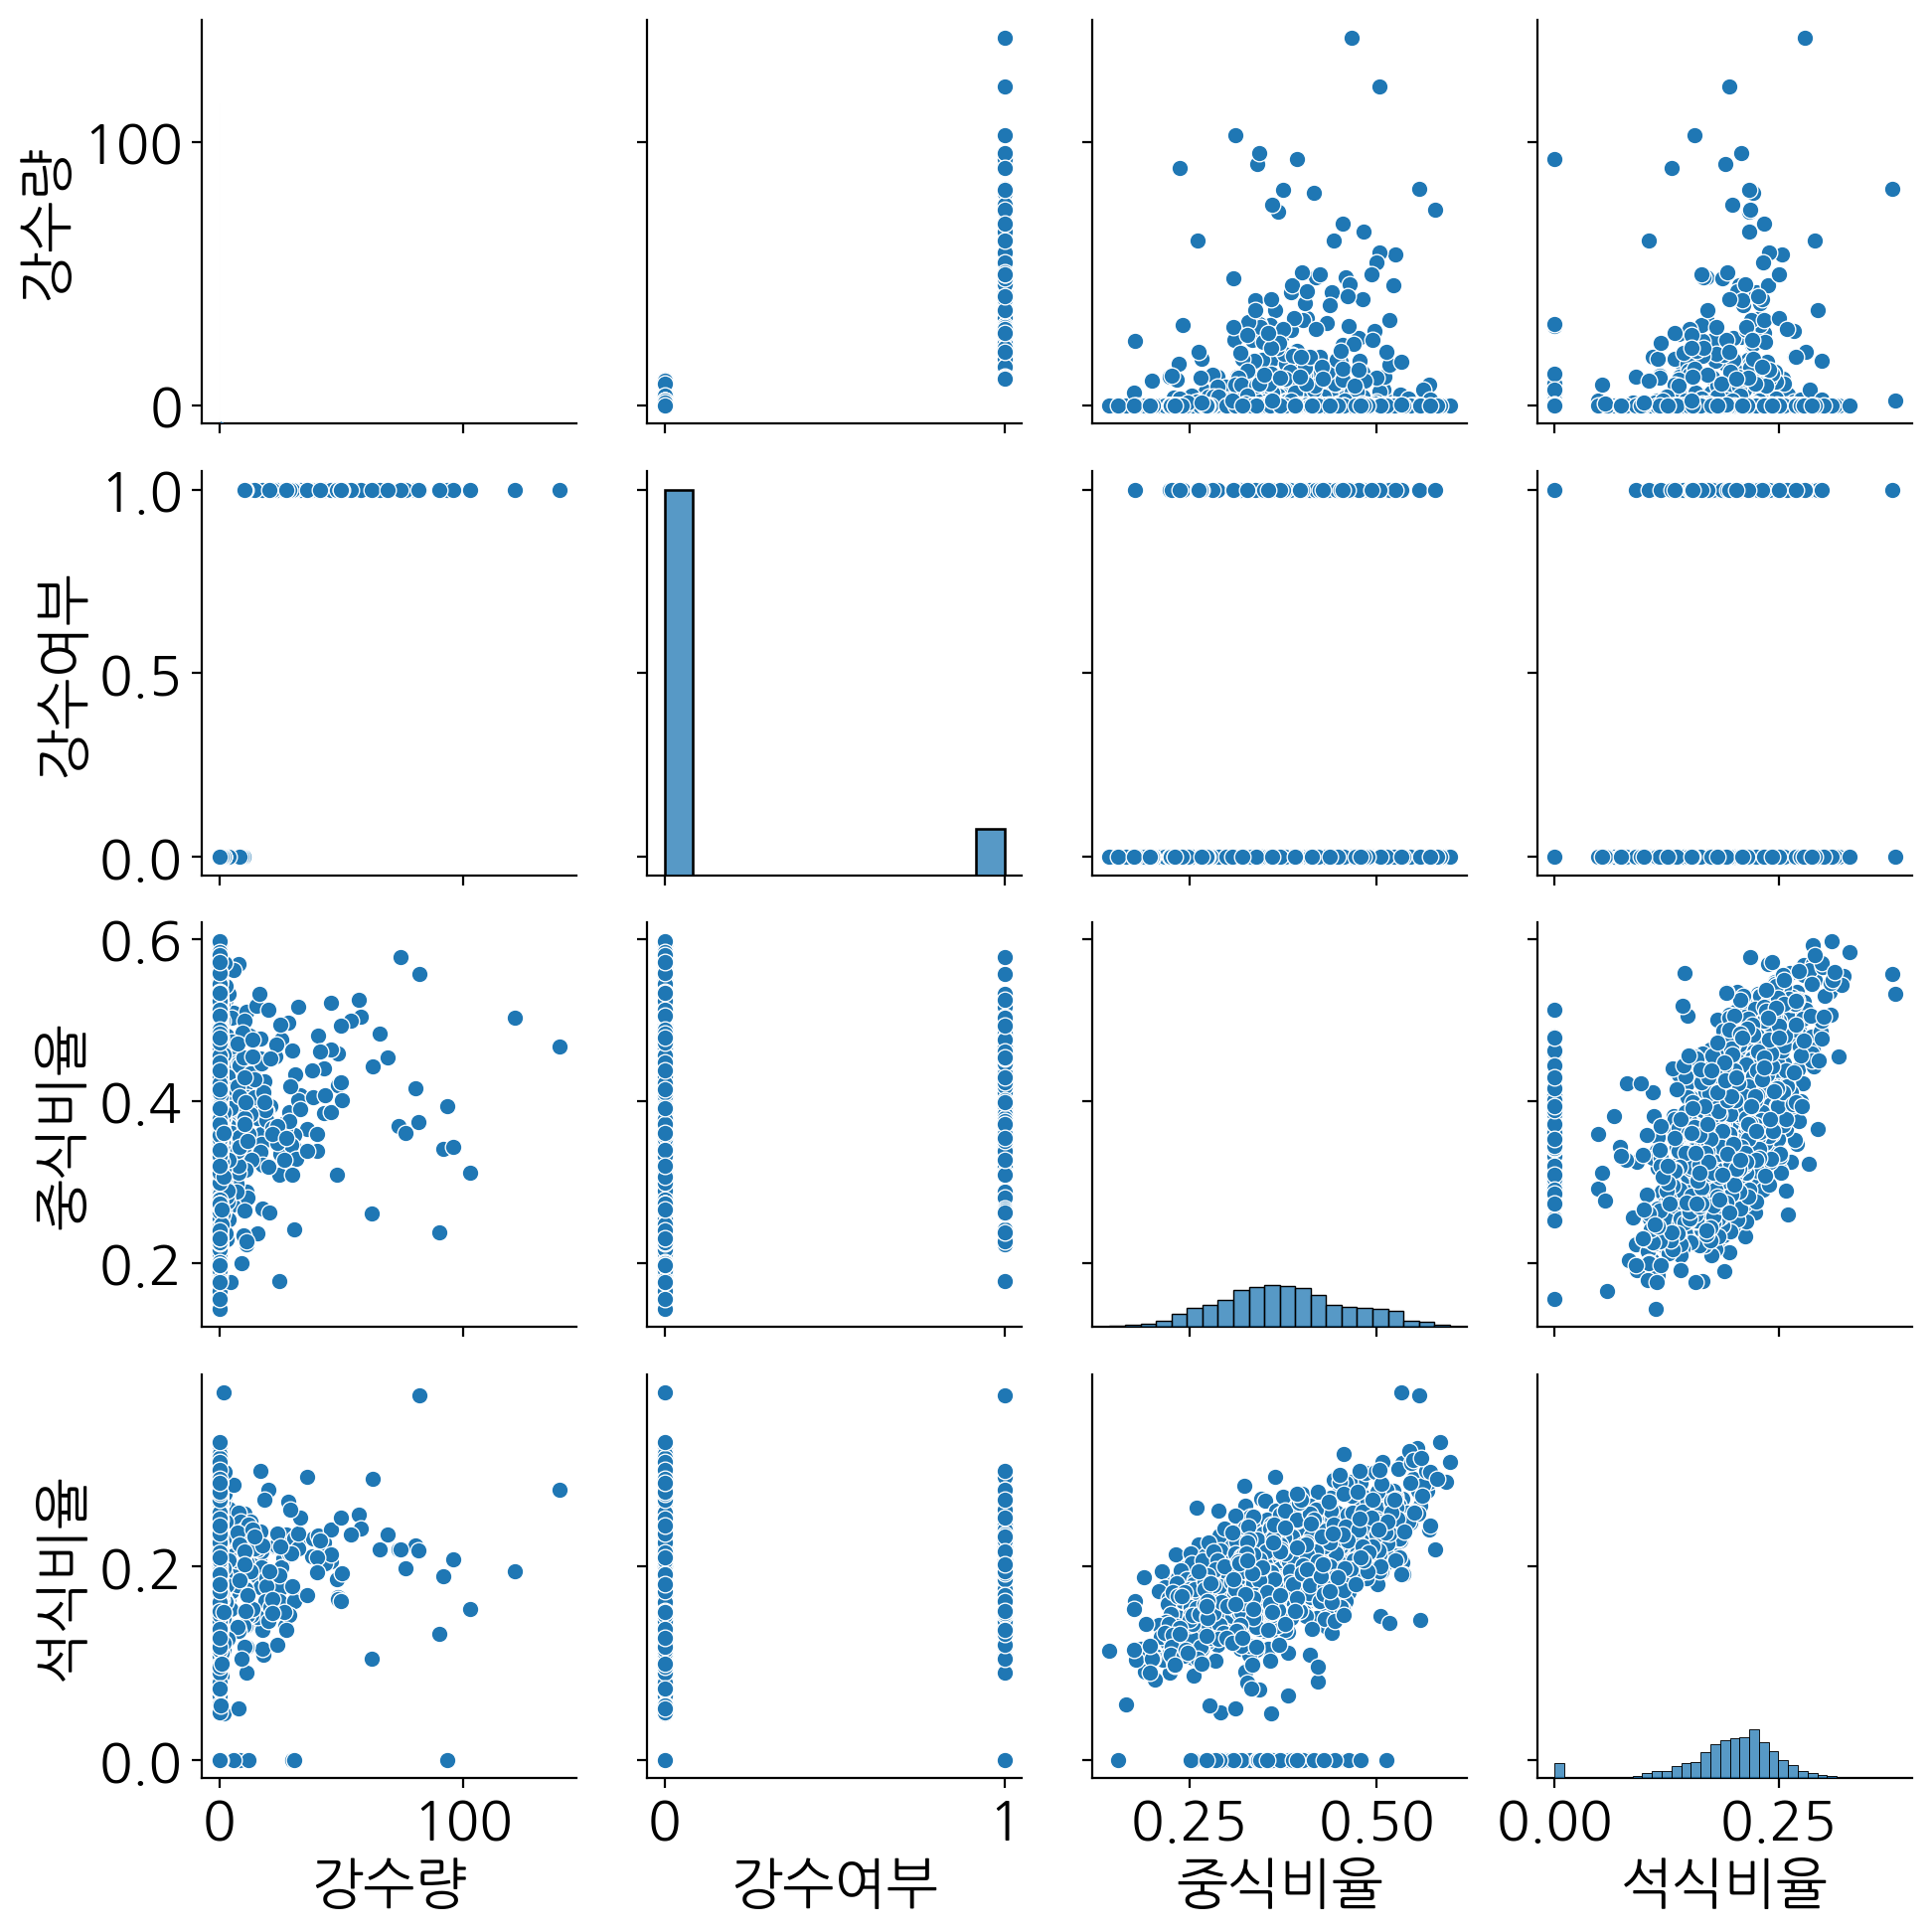

In [558]:
sns.pairplot(train6[['강수량', '강수여부', '중식비율', '석식비율']])

In [559]:
train6[train6['일자']=='2017-12-28']

,일자,연도,월,일,요일,출근인원,본사시간외근무명령서승인건수,강수량,중식메뉴,석식메뉴,중식_신메뉴,석식_신메뉴,중식계,석식계,중식비율,석식비율,강수여부
469,2017-12-28,2017,12,28,4,2165,55,0.0,쌀밥/잡곡밥 (쌀:국내산) 아욱된장국 돼지갈비찜 콩나물겨자채 참나물무침 포기...,쌀밥/잡곡밥 (쌀:국내산) 옛날왕돈까스 크림스프 감자범벅/오이피클 과일샐러드 ...,0,0,311,245,0.143649,0.113164,0


## ML

* 데이터 목록

In [145]:
weather2 = pd.read_csv("raining_test.csv",encoding='cp949')
del weather2['지점']
del weather2['지점명']
weather2['일시'] = weather2['일시'].astype('datetime64')
test['일자'] = test['일자'].astype('datetime64')
a = pd.merge(test,weather2,how='left',left_on='일자',right_on='일시')
a = a.drop('일시',axis=1)
a['일강수량(mm)'] = a['일강수량(mm)'].fillna(0)



In [146]:
test = a.copy()


In [147]:
test['강수량'] = test['일강수량(mm)']
test.drop(columns='일강수량(mm)')
test.head()

,일자,연도,월,일,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,...,석식_찜,석식_볶음,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법,일강수량(mm),강수량
0,2021-01-27,2021,1,27,3,2983,88,182,5,358,...,0.0,1.0,0.0,0.0,0.0,0.0,4,1,0.0,0.0
1,2021-01-28,2021,1,28,4,2983,104,212,409,348,...,0.0,0.0,0.0,0.0,0.0,0.0,2,5,0.0,0.0
2,2021-01-29,2021,1,29,5,2983,270,249,0,294,...,1.0,0.0,0.0,0.0,0.0,0.0,7,4,0.0,0.0
3,2021-02-01,2021,2,1,1,2924,108,154,538,322,...,0.0,0.0,1.0,0.0,0.0,0.0,2,6,16.0,16.0
4,2021-02-02,2021,2,2,2,2924,62,186,455,314,...,0.0,1.0,0.0,0.0,0.0,0.0,6,1,0.0,0.0


In [148]:
train.head(1)

,일자,연도,월,일,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,...,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법,중식계,석식계,중식비율,석식비율
0,2016-02-01,2016,2,1,1,2601,50,150,238,0,...,0.0,0.0,0.0,1.0,2,9,1039,331,0.432736,0.137859


In [149]:
test.head(1)

,일자,연도,월,일,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,...,석식_찜,석식_볶음,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법,일강수량(mm),강수량
0,2021-01-27,2021,1,27,3,2983,88,182,5,358,...,0.0,1.0,0.0,0.0,0.0,0.0,4,1,0.0,0.0


In [568]:
train_lunch.head(1)

,연도,월,일,요일,출근인원,중식_신메뉴,휴일전날,중식_전,중식_무침,중식_튀김,...,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료,중식계
0,2016,2,1,1,2401,0,0.0,0.0,0.0,0.0,...,오징어찌개,쇠불고기,계란찜,청포묵무침,포기김치,요구르트,소,기타,기타,1039


In [569]:
train_dinner.head(1)

,연도,월,일,요일,출근인원,석식_신메뉴,휴일전날,석식_전,석식_무침,석식_튀김,...,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료,석식계
0,2016,2,1,1,2401,0,0.0,0.0,0.0,0.0,...,육개장,자반고등어구이,두부조림,건파래무침,포기김치,건파래무침,해산물,채소,기타,331


In [570]:
test_lunch.head(1)

,연도,월,일,요일,출근인원,중식_신메뉴,휴일전날,중식_전,중식_무침,중식_튀김,...,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2021,1,27,3,2355,0,0.0,0.0,0.0,0.0,...,쌀밥/흑미밥/찰현미밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,양상추샐러드*딸기D,포기김치,소,기타,기타


In [571]:
test_dinner.head(1)

,연도,월,일,요일,출근인원,석식_신메뉴,휴일전날,석식_전,석식_무침,석식_튀김,...,밥,국,반찬1,반찬2,반찬3,김치,사이드,반찬1_원재료,반찬2_원재료,반찬3_원재료
0,2021,1,27,3,2355,1,0.0,0.0,0.0,0.0,...,흑미밥,얼큰순두부찌개,쇠고기우엉볶음,버섯햄볶음,포기김치,포기김치,버섯햄볶음,소,기타,기타


In [572]:
train.columns, test.columns


(Index(['일자', '연도', '월', '일', '요일', '본사정원수', '본사휴가자수', '본사출장자수',
        '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '출근인원', '휴일전날', '초복', '중복', '말복', '동지',
        '수능', '어버이날', '유등축제', '강수량', '조식메뉴', '중식메뉴', '석식메뉴', '중식_신메뉴', '석식_신메뉴',
        '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제',
        '중식_조리_기타', '석식_전', '석식_무침', '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이',
        '석식_훈제', '석식_조리_기타', '중식메인조리법', '석식메인조리법', '중식계', '석식계', '중식비율',
        '석식비율'],
       dtype='object'),
 Index(['일자', '연도', '월', '일', '요일', '본사정원수', '본사휴가자수', '본사출장자수',
        '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '출근인원', '휴일전날', '조식메뉴', '중식메뉴', '석식메뉴',
        '중식_신메뉴', '석식_신메뉴', '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음', '중식_조림',
        '중식_구이', '중식_훈제', '중식_조리_기타', '석식_전', '석식_무침', '석식_튀김', '석식_찜', '석식_볶음',
        '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타', '중식메인조리법', '석식메인조리법', '일강수량(mm)',
        '강수량'],
       dtype='object'))

In [573]:
train_lunch.columns, test_lunch.columns, train_dinner.columns, test_dinner.columns

(Index(['연도', '월', '일', '요일', '출근인원', '중식_신메뉴', '휴일전날', '중식_전', '중식_무침',
        '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타',
        '중식메인조리법', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료', '중식계'],
       dtype='object'),
 Index(['연도', '월', '일', '요일', '출근인원', '중식_신메뉴', '휴일전날', '중식_전', '중식_무침',
        '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타',
        '중식메인조리법', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료'],
       dtype='object'),
 Index(['연도', '월', '일', '요일', '출근인원', '석식_신메뉴', '휴일전날', '석식_전', '석식_무침',
        '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
        '석식메인조리법', '밥', '국', '반찬1', '반찬2', '반찬3', '김치', '사이드', '반찬1_원재료',
        '반찬2_원재료', '반찬3_원재료', '석식계'],
       dtype='object'),
 Index(['연도', '월', '일', '요일', '출근인원', '석식_신메뉴', '휴일전날', '석식_전', '석식_무침',
        '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타',
        '석식메인조리

### 
 - ExtraTreesRegressor
 - 그리드서치 
 ```
 parameters = {'n_estimators':(300, 500, 700),
              'max_depth':(10, 13, 15),
              'min_samples_split': (2, 5, 10),
             'max_features':('auto', 'sqrt', 'log2')}
```

 - 중식계
 - 기본 칼럼 
 ```
 train[['본사정원수', '본사휴가자수',
        '본사출장자수', '본사시간외근무명령서승인건수',
        '현본사소속재택근무자수']]
```

In [619]:
# 그리드서치 (중식계)

In [620]:
X_train = train[['본사정원수', '본사휴가자수',
                            '본사출장자수', '본사시간외근무명령서승인건수',
                            '현본사소속재택근무자수']]
X_train.head()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,2601,50,150,238,0
1,2601,50,173,319,0
2,2601,56,180,111,0
3,2601,104,220,355,0
4,2601,278,181,34,0


In [621]:
y_train = train[['중식계', '석식계']]
y_train.head()

,중식계,석식계
0,1039,331
1,867,560
2,1017,573
3,978,525
4,925,330


In [622]:
X_test = test[['본사정원수', '본사휴가자수',
                            '본사출장자수', '본사시간외근무명령서승인건수',
                            '현본사소속재택근무자수']]
X_test.head()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,2983,88,182,5,358
1,2983,104,212,409,348
2,2983,270,249,0,294
3,2924,108,154,538,322
4,2924,62,186,455,314


In [623]:
# model

from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(random_state=42)
                                  
model

ExtraTreesRegressor(random_state=42)

In [624]:
parameters = {'n_estimators':(300, 500, 700),
              'max_depth':(10, 13, 15),
              'min_samples_split': (2, 5, 10),
             'max_features':('auto', 'sqrt', 'log2')}
parameters

{'n_estimators': (300, 500, 700),
 'max_depth': (10, 13, 15),
 'min_samples_split': (2, 5, 10),
 'max_features': ('auto', 'sqrt', 'log2')}

In [625]:
from sklearn.model_selection import GridSearchCV

reg = GridSearchCV(model, parameters, n_jobs=-1, cv=5, verbose=2)
reg.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': (10, 13, 15),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'min_samples_split': (2, 5, 10),
                         'n_estimators': (300, 500, 700)},
             verbose=2)

In [626]:
y_predict = model.fit(X_train, y_train).predict(X_test)
y_predict[:5]

array([[1013.71,  378.44],
       [1015.78,  430.99],
       [ 603.88,  244.09],
       [1096.54,  533.97],
       [1010.45,  474.99]])

In [627]:
best_model = reg.best_estimator_
best_model

ExtraTreesRegressor(max_depth=15, max_features='sqrt', min_samples_split=5,
                    n_estimators=300, random_state=42)

In [628]:
reg.best_score_

0.4854242275830085

In [629]:
from sklearn.model_selection import cross_val_predict

y_valid_predict = cross_val_predict(reg.best_estimator_, 
                                   X_train, y_train,
                                   cv=5, n_jobs=-1, verbose=2)
y_valid_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


array([[1023.5552597 ,  500.51457541],
       [1042.81730796,  521.23142482],
       [1035.79938297,  488.93601964],
       [1082.53918519,  520.17290581],
       [ 822.17717529,  311.12032021]])

In [630]:
best_model = reg.best_estimator_
best_model

ExtraTreesRegressor(max_depth=15, max_features='sqrt', min_samples_split=5,
                    n_estimators=300, random_state=42)

In [631]:
# 평가

In [632]:
# MSE

(((y_train) - (y_valid_predict))**2).mean()

중식계    14095.350304
석식계    11879.180472
dtype: float64

In [633]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_valid_predict)

12987.265387796311

<AxesSubplot:>

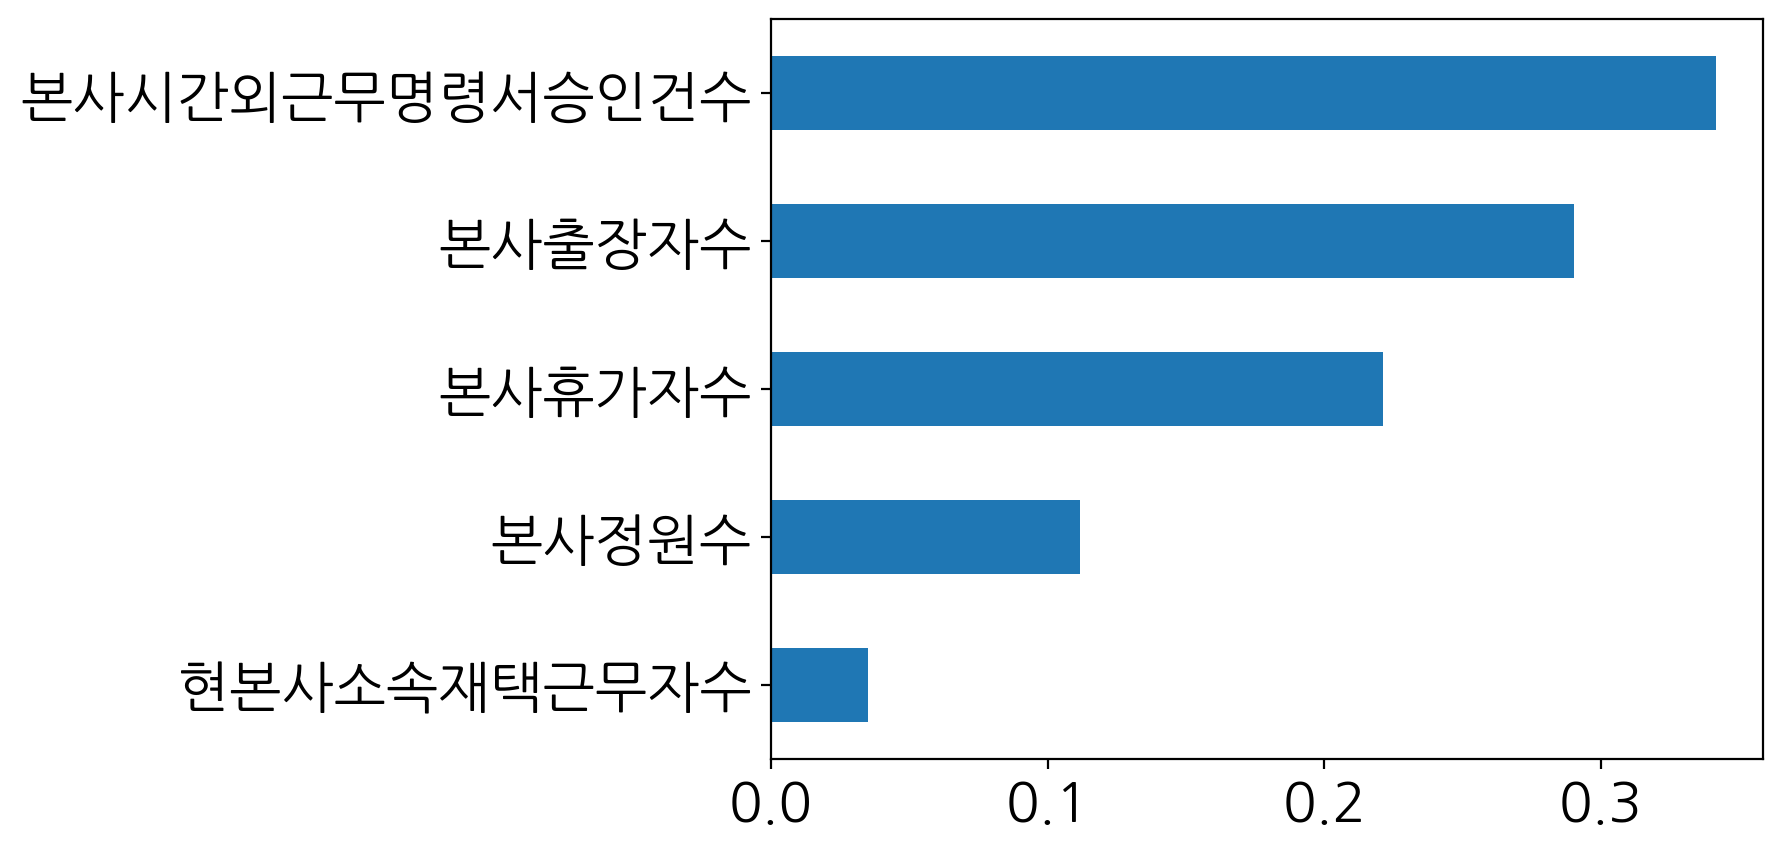

In [634]:
# 피처 중요도

fi = pd.Series(model.feature_importances_)
fi.index = model.feature_names_in_
fi.sort_values().plot.barh()

In [635]:
# 제출

In [636]:
submit = pd.read_csv("sample_submission.csv")
submit.shape

(50, 3)

In [637]:
submit[['중식계', '석식계']] = y_predict

In [638]:
submit.head()

,일자,중식계,석식계
0,2021-01-27,1013.71,378.44
1,2021-01-28,1015.78,430.99
2,2021-01-29,603.88,244.09
3,2021-02-01,1096.54,533.97
4,2021-02-02,1010.45,474.99


In [639]:
name = 'Extratree1'
name

submit.to_csv(f'submit_{name}.csv', index=False)


In [640]:
pd.read_csv(f'submit_{name}.csv')

,일자,중식계,석식계
0,2021-01-27,1013.71,378.44
1,2021-01-28,1015.78,430.99
2,2021-01-29,603.88,244.09
3,2021-02-01,1096.54,533.97
4,2021-02-02,1010.45,474.99
5,2021-02-03,993.86,414.40
6,2021-02-04,958.68,467.20
7,2021-02-05,651.37,322.63
8,2021-02-08,1065.45,589.44
9,2021-02-09,1020.93,521.49


### 

 - Decision Tree
 - 그리드서치
 

In [574]:
X_train = train[['출근인원', '휴일전날', '강수량', '중식_신메뉴', '석식_신메뉴',
                '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제',
        '중식_조리_기타', '석식_전', '석식_무침', '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이',
        '석식_훈제', '석식_조리_기타', '중식메인조리법', '석식메인조리법']]
X_train

,출근인원,휴일전날,강수량,중식_신메뉴,석식_신메뉴,중식_전,중식_무침,중식_튀김,중식_찜,중식_볶음,...,석식_무침,석식_튀김,석식_찜,석식_볶음,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법
0,2401,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,9
1,2378,0.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
2,2365,0.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
3,2277,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,9
4,2142,1.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2319,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,5
1201,2309,0.0,1.7,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,2
1202,2177,1.0,1.2,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,4
1203,2396,0.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7


In [575]:
y_train = train[['중식계', '석식계']]
y_train.head()

,중식계,석식계
0,1039,331
1,867,560
2,1017,573
3,978,525
4,925,330


In [577]:
X_test = test[['출근인원', '휴일전날', '강수량', '중식_신메뉴', '석식_신메뉴',
                '중식_전', '중식_무침', '중식_튀김', '중식_찜', '중식_볶음', '중식_조림', '중식_구이', '중식_훈제',
        '중식_조리_기타', '석식_전', '석식_무침', '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이',
        '석식_훈제', '석식_조리_기타', '중식메인조리법', '석식메인조리법']]
X_test.head()

,출근인원,휴일전날,강수량,중식_신메뉴,석식_신메뉴,중식_전,중식_무침,중식_튀김,중식_찜,중식_볶음,...,석식_무침,석식_튀김,석식_찜,석식_볶음,석식_조림,석식_구이,석식_훈제,석식_조리_기타,중식메인조리법,석식메인조리법
0,2355,0.0,0.0,0,1,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4,1
1,2319,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5
2,2170,1.0,0.0,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,4
3,2340,0.0,16.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,6
4,2362,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6,1


In [578]:
# model

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
                                  
model

DecisionTreeRegressor(random_state=42)

In [594]:
parameters = {'max_depth':(7, 10, 15),
              'min_samples_split': (5, 10, 15, 20),
              'max_features':('auto', 'sqrt', 'log2')}
parameters

{'max_depth': (7, 10, 15),
 'min_samples_split': (5, 10, 15, 20),
 'max_features': ('auto', 'sqrt', 'log2')}

In [595]:
from sklearn.model_selection import GridSearchCV

reg = GridSearchCV(model, parameters, n_jobs=-1, cv=5, verbose=2)
reg.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': (7, 10, 15),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'min_samples_split': (5, 10, 15, 20)},
             verbose=2)

In [596]:
y_predict = model.fit(X_train, y_train).predict(X_test)
y_predict[:5]

array([[1257.,  451.],
       [ 796.,  459.],
       [ 702.,  277.],
       [ 832.,  353.],
       [1257.,  451.]])

In [597]:
best_model = reg.best_estimator_
best_model

DecisionTreeRegressor(max_depth=7, max_features='auto', min_samples_split=20,
                      random_state=42)

In [598]:
reg.best_score_

0.08606554826536422

In [599]:
from sklearn.model_selection import cross_val_predict

y_valid_predict = cross_val_predict(reg.best_estimator_, 
                                   X_train, y_train,
                                   cv=5, n_jobs=-1, verbose=2)
y_valid_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


array([[996.06690141, 499.0528169 ],
       [900.57142857, 412.25714286],
       [900.57142857, 412.25714286],
       [996.06690141, 499.0528169 ],
       [632.45945946, 400.33108108]])

In [ ]:
# 평가

In [612]:
# MSE

(((y_train) - (y_valid_predict))**2).mean()

중식계    31315.005658
석식계    19192.113537
dtype: float64

In [610]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_valid_predict)

25253.5595973471

<AxesSubplot:>

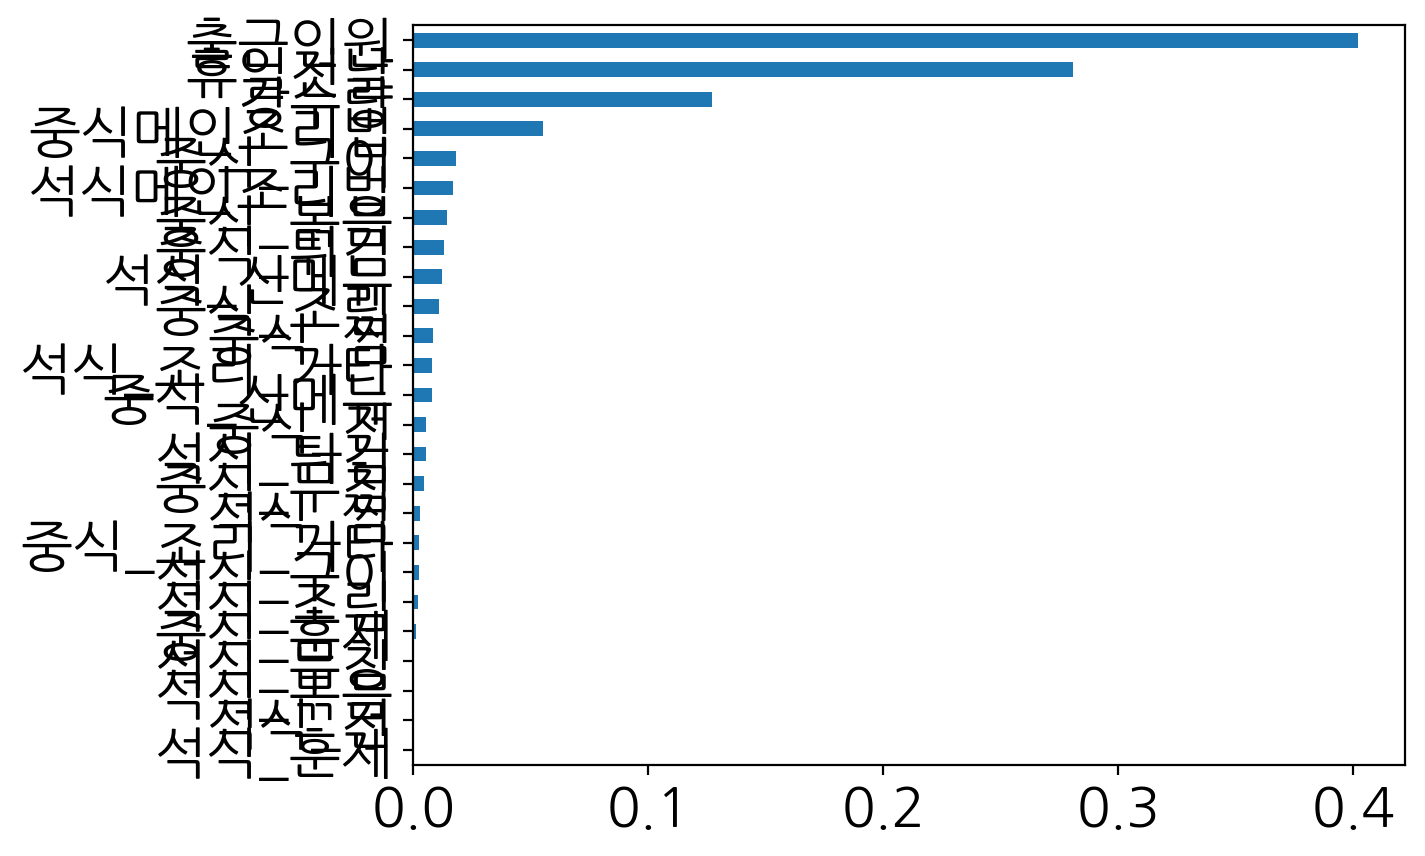

In [613]:
# 피처 중요도

fi = pd.Series(model.feature_importances_)
fi.index = model.feature_names_in_
fi.sort_values().plot.barh()

In [614]:
# 제출

submit = pd.read_csv("sample_submission.csv")
submit[['중식계', '석식계']] = y_predict

In [641]:
name = 'DecisionTree1'
name

submit.to_csv(f'submit_{name}.csv', index=False)

In [642]:
pd.read_csv(f'submit_{name}.csv')

,일자,중식계,석식계
0,2021-01-27,1013.71,378.44
1,2021-01-28,1015.78,430.99
2,2021-01-29,603.88,244.09
3,2021-02-01,1096.54,533.97
4,2021-02-02,1010.45,474.99
5,2021-02-03,993.86,414.40
6,2021-02-04,958.68,467.20
7,2021-02-05,651.37,322.63
8,2021-02-08,1065.45,589.44
9,2021-02-09,1020.93,521.49


### 
- CatBoost

In [150]:
X_train = train[['출근인원', '휴일전날', '강수량',
                 '중식메인조리법', '석식메인조리법']]
X_train.head()

,출근인원,휴일전날,강수량,중식메인조리법,석식메인조리법
0,2401,0.0,0.0,2,9
1,2378,0.0,0.0,7,9
2,2365,0.0,0.0,7,9
3,2277,0.0,0.0,1,9
4,2142,1.0,0.0,7,9


In [151]:
y_train = train[['중식계', '석식계']]
y_train.head()

,중식계,석식계
0,1039,331
1,867,560
2,1017,573
3,978,525
4,925,330


In [152]:
X_test = test[['출근인원', '휴일전날', '강수량',
                 '중식메인조리법', '석식메인조리법']]
X_test.head()

,출근인원,휴일전날,강수량,중식메인조리법,석식메인조리법
0,2355,0.0,0.0,4,1
1,2319,0.0,0.0,2,5
2,2170,1.0,0.0,7,4
3,2340,0.0,16.0,2,6
4,2362,0.0,0.0,6,1


In [153]:
import catboost

In [156]:
model_cat = catboost.CatBoostRegressor(eval_metric='R2')
model_cat

In [167]:
parameters = {'learning_rate':(0.05, 0.1, 0.2),
              'n_estimators':(500, 1000, 1500),
              'max_depth':(3, 6, 9),
              'colsample_bylevel':(1, 2, 3)}
parameters

{'learning_rate': (0.05, 0.1, 0.2),
 'n_estimators': (500, 1000, 1500),
 'max_depth': (3, 6, 9),
 'colsample_bylevel': (1, 2, 3)}

In [168]:
from sklearn.model_selection import GridSearchCV

reg = GridSearchCV(model_cat, parameters, n_jobs=-1, cv=5, verbose=2)
reg.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
405 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 2355, in _fit
   

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/data_providers.cpp:612: Currently only multi-regression, multilabel and survival objectives work with multidimensional target

In [ ]:
result = model_cat.randomized_search(param_grid,
                                     X_train, y_train,
                                     cv=3, n_iter=10,
                                     verbose=False)
result

In [ ]:
# fit

model_cat.fit(X_train, y_train)

In [ ]:
# valid score
# score_cat

score_cat = model_cat.score(X_valid, y_valid)
score_cat

In [ ]:
# predict
# y_pred_cat

y_pred_cat = model_cat.predict(X_test)
y_pred_cat[:5]